# Proyecto 02: Detección de Anomalías
## Fernando Daniel Brenes Reyes - 2020097446@estudiantec.cr
## Jose Pablo Quesada Rodriguez - josepabloqr15@estudiantec.cr
## Ashley Vasquez Concepcion - ashley19@estudiantec.cr

#### Imports

In [ ]:
import os
import sys
import time
import copy
from pathlib import Path
from datetime import datetime

sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
import torch.ao.quantization
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

import wandb
from omegaconf import OmegaConf
from hydra import initialize, compose, initialize_config_dir
from hydra.core.global_hydra import GlobalHydra

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.covariance import LedoitWolf
from sklearn.metrics import (
    roc_auc_score, 
    roc_curve, 
    accuracy_score, 
    confusion_matrix, 
    recall_score
)
from scipy.spatial.distance import mahalanobis

from src.data.mvtec_datamodule import MVTecDataModule

In [ ]:

def get_project_root():
    if '__file__' not in globals():
        return Path(os.getcwd()).resolve()
    else:
        return Path(__file__).resolve().parent

project_root = get_project_root()
sys.path.insert(0, str(project_root))

print("Project root:", project_root)
print("Contenido:", os.listdir(project_root))

Project root: E:\IA\ProyectoAnomalias
Contenido: ['.git', '.gitignore', '.vscode', 'anomalias.ipynb', 'checkpoints', 'conf', 'Images', 'logs', 'Proyectos_Proyecto_II.pdf', 'src', 'trainer-project', 'train_model.py', '__pycache__']


### Se toman las 10 carpetas (cable, capsule, grid, hazelnut, leather, metal_nut, pill, screw, tile, transistor) y se separa su información de testing training y se juntan en un solo dataset, igualmente guardando las etiquetas y se setea el tamaño de cada imagen en 128x128

# Modelos entrenamiento

## Entrenamiento de Modelos ResNet para MVTec AD,
   ### Modelo A_1: Scratch | Modelo A_2: Distilled,
Este notebook entrena modelos con diferentes configuraciones usando Hydra + PyTorch Lightning + WandB"

In [ ]:
print(f"PyTorch: {torch.__version__}")
print(f"Lightning: {pl.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.6.0+cu124
Lightning: 2.6.0
CUDA available: True
GPU: NVIDIA GeForce RTX 3060


#### Configuracion con hydra
Hydra permite cargar configuraciones de maneras modulares y hacer override desde el notebook

In [ ]:
GlobalHydra.instance().clear()

initialize(config_path="./conf", version_base="1.3")

cfg = compose(config_name="config")

print("\n=== CONFIGURACIÓN CARGADA ===")
print(OmegaConf.to_yaml(cfg))


=== CONFIGURACIÓN CARGADA ===
model:
  loss:
    name: cross_entropy
    type: classification
    label_smoothing: 0.0
    weight: null
  optimizer:
    name: adam
    learning_rate: 0.001
    weight_decay: 0.0001
    betas:
    - 0.9
    - 0.999
    eps: 1.0e-08
    amsgrad: false
    scheduler:
      name: cosine
      enabled: true
      T_max: 100
      eta_min: 1.0e-06
  name: resnet_scratch
  type: scratch
  latent_dim: 128
  dropout: 0.3
  use_batch_norm: true
  learning_rate: 0.001
  weight_decay: 0.0001
  batch_size: 32
  max_epochs: 100
trainer:
  trainer: null
  accelerator: auto
  devices: 1
  precision: 32
  max_epochs: 100
logger:
  name: wandb
  project: mvtec-anomaly-detection
  entity: null
  save_dir: ./logs
  log_model: true
  log_gradients: false
  log_graph: false
  offline: false
  tags: []
  notes: null
loss:
  name: cross_entropy
  type: classification
  label_smoothing: 0.0
  weight: null
optimizer:
  name: adam
  learning_rate: 0.001
  weight_decay: 0.0001
  

### Preparar DataModule

In [7]:
pl.seed_everything(cfg.seed, workers=True)

datamodule = MVTecDataModule(
    data_dir=cfg.data.data_dir,
    class_names=cfg.class_names,
    batch_size=cfg.data.batch_size,
    num_workers=cfg.data.num_workers,
    pin_memory=cfg.data.pin_memory
)

datamodule.setup()

print("\n=== DATASET STATISTICS ===")
stats = datamodule.get_num_samples()
print(f"Train samples:      {stats['train']}")
print(f"Validation samples: {stats['val']}")
print(f"Test samples:       {stats['test']}")
print(f"\nBatch size: {cfg.data.batch_size}")
print(f"Train batches per epoch: {stats['train'] // cfg.data.batch_size}")


Seed set to 42



=== DATASET STATISTICS ===
Train samples:      2072
Validation samples: 521
Test samples:       1253

Batch size: 32
Train batches per epoch: 64


### Funcion de entrenamiento

#### Entrenamiento Modelos ResNet - MVTec Anomaly Detection


In [ ]:

def get_project_root():
    
    return Path(os.getcwd()).resolve()

project_root = get_project_root()


src_path = project_root / "src"
if src_path.exists():
    sys.path.insert(0, str(src_path))
else:
    sys.path.insert(0, str(project_root))

print("Project root:", project_root)
print("sys.path[0]:", sys.path[0])

from train_model import train_model, load_trained_model

Project root: E:\IA\ProyectoAnomalias
sys.path[0]: E:\IA\ProyectoAnomalias\src


####  Cargar Configuración Base

In [ ]:
try:
    GlobalHydra.instance().clear()
except Exception:
    # safe fallback if GlobalHydra not initialized
    pass
# Inicializar Hydra con path absoluto
config_dir = str(project_root / "conf")
initialize_config_dir(config_dir=config_dir, version_base=None)

# Cargar config base
cfg = compose(config_name="config")


print("="*80)
print("CONFIGURACIÓN BASE")
print("="*80)
print(OmegaConf.to_yaml(cfg))

CONFIGURACIÓN BASE
model:
  loss:
    name: cross_entropy
    type: classification
    label_smoothing: 0.0
    weight: null
  optimizer:
    name: adam
    learning_rate: 0.001
    weight_decay: 0.0001
    betas:
    - 0.9
    - 0.999
    eps: 1.0e-08
    amsgrad: false
    scheduler:
      name: cosine
      enabled: true
      T_max: 100
      eta_min: 1.0e-06
  name: resnet_scratch
  type: scratch
  latent_dim: 128
  dropout: 0.3
  use_batch_norm: true
  learning_rate: 0.001
  weight_decay: 0.0001
  batch_size: 32
  max_epochs: 100
trainer:
  trainer: null
  accelerator: auto
  devices: 1
  precision: 32
  max_epochs: 100
logger:
  name: wandb
  project: mvtec-anomaly-detection
  entity: null
  save_dir: ./logs
  log_model: true
  log_gradients: false
  log_graph: false
  offline: false
  tags: []
  notes: null
loss:
  name: cross_entropy
  type: classification
  label_smoothing: 0.0
  weight: null
optimizer:
  name: adam
  learning_rate: 0.001
  weight_decay: 0.0001
  betas:
  - 0

### Carga de Checkpoints

In [ ]:
def get_or_train_model(cfg, datamodule, model_type, force_retrain=True):
    """
    Busca si ya existe un checkpoint entrenado.
    Si existe: Lo carga y devuelve el modelo.
    Si NO existe (o force_retrain=True): Entrena el modelo usando train_model.
    """
    if cfg.experiment.run_name:
        run_name = cfg.experiment.run_name
    else:
        run_name = f"{cfg.model.name}_z{cfg.model.latent_dim}"
        
    checkpoint_dir = Path(f'./checkpoints/{run_name}')
    
    existing_ckpts = list(checkpoint_dir.glob('*.ckpt'))
    best_ckpt = None
    for ckpt in existing_ckpts:
        if "best" in ckpt.name:
            best_ckpt = ckpt
            break
    if best_ckpt is None and existing_ckpts:
        best_ckpt = existing_ckpts[0] 
    if best_ckpt and not force_retrain:
        print(f"\nModelo encontrado en: {best_ckpt}")
        print("   -> Cargando pesos guardados (saltando entrenamiento)...")
        
        model = load_trained_model(str(best_ckpt), model_type=model_type)
        
        trainer = pl.Trainer(accelerator='auto', devices=1, logger=False)
        
        return trainer, model
        
    else:
        if force_retrain and best_ckpt:
            print(f"\nForzando re-entrenamiento (Sobreescribiendo {run_name})...")
        else:
            print(f"\nNo se encontró checkpoint previo. Iniciando entrenamiento: {run_name}...")
            
        return train_model(cfg=cfg, datamodule=datamodule, model_type=model_type)

# Experiments: Autoencoder Unet

### EXPERIMENTO 1: U-Net con MSE Loss

In [11]:
cfg_unet_mse = compose(
    config_name="config",
    overrides=[
        "model=unet_autoencoder",
        "loss=mse",
        "experiment.run_name=unet_z128_mse",
        "callbacks.early_stopping.patience=3",
        "callbacks.early_stopping.min_delta=0.0"
    ]
)

trainer_u1, model_u1 = get_or_train_model(
    cfg=cfg_unet_mse,
    datamodule=datamodule,
    model_type="autoencoder"
)

wandb: WARNING The anonymous setting has no effect and will be removed in a future version.



No se encontró checkpoint previo. Iniciando entrenamiento: unet_z128_mse...

 Run Name: unet_z128_mse


wandb: Currently logged in as: fdbrenes17 (fdbrenes17-tec-costa-rica) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision



=== INICIANDO ENTRENAMIENTO: unet_z128_mse ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode  | FLOPs
-----------------------------------------------------------------
0 | enc_blocks  | ModuleList       | 1.2 M  | train | 0    
1 | downsamples | ModuleList       | 348 K  | train | 0    
2 | bottleneck  | UNetEncoderBlock | 3.5 M  | train | 0    
3 | dec_blocks  | ModuleList       | 3.0 M  | train | 0    
4 | final_conv  | Conv2d           | 99     | train | 0    
5 | activation  | Sigmoid          | 0      | train | 0    
6 | criterion   | MSELoss          | 0      | train | 0    
-----------------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.435    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 65/65 [00:10<00:00,  6.31it/s, v_num=kgfi, val/loss=0.00376, train/loss=0.020]

Metric val/loss improved. New best score: 0.004
Epoch 0, global step 65: 'val/loss' reached 0.00376 (best 0.00376), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=00-val/loss=0.0038.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:10<00:00,  6.34it/s, v_num=kgfi, val/loss=0.00142, train/loss=0.00225]

Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.001
Epoch 1, global step 130: 'val/loss' reached 0.00142 (best 0.00142), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=01-val/loss=0.0014.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:10<00:00,  6.43it/s, v_num=kgfi, val/loss=0.00113, train/loss=0.00135]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 2, global step 195: 'val/loss' reached 0.00113 (best 0.00113), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=02-val/loss=0.0011.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:10<00:00,  6.44it/s, v_num=kgfi, val/loss=0.00111, train/loss=0.00111]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 3, global step 260: 'val/loss' reached 0.00111 (best 0.00111), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=03-val/loss=0.0011.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:10<00:00,  6.10it/s, v_num=kgfi, val/loss=0.000859, train/loss=0.000986]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 4, global step 325: 'val/loss' reached 0.00086 (best 0.00086), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=04-val/loss=0.0009.ckpt' as top 3


Epoch 5: 100%|██████████| 65/65 [00:10<00:00,  6.36it/s, v_num=kgfi, val/loss=0.000877, train/loss=0.000871]

Epoch 5, global step 390: 'val/loss' reached 0.00088 (best 0.00086), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=05-val/loss=0.0009.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:10<00:00,  6.36it/s, v_num=kgfi, val/loss=0.000661, train/loss=0.000789]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 6, global step 455: 'val/loss' reached 0.00066 (best 0.00066), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=06-val/loss=0.0007.ckpt' as top 3


Epoch 7: 100%|██████████| 65/65 [00:10<00:00,  6.44it/s, v_num=kgfi, val/loss=0.00059, train/loss=0.000668] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 7, global step 520: 'val/loss' reached 0.00059 (best 0.00059), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=07-val/loss=0.0006.ckpt' as top 3


Epoch 8: 100%|██████████| 65/65 [00:09<00:00,  6.64it/s, v_num=kgfi, val/loss=0.000549, train/loss=0.000624]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 8, global step 585: 'val/loss' reached 0.00055 (best 0.00055), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=08-val/loss=0.0005.ckpt' as top 3


Epoch 9: 100%|██████████| 65/65 [00:09<00:00,  6.55it/s, v_num=kgfi, val/loss=0.00053, train/loss=0.000603] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 9, global step 650: 'val/loss' reached 0.00053 (best 0.00053), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=09-val/loss=0.0005.ckpt' as top 3


Epoch 10: 100%|██████████| 65/65 [00:10<00:00,  6.44it/s, v_num=kgfi, val/loss=0.0011, train/loss=0.000618] 

Epoch 10, global step 715: 'val/loss' was not in top 3


Epoch 11: 100%|██████████| 65/65 [00:09<00:00,  6.54it/s, v_num=kgfi, val/loss=0.000512, train/loss=0.000573]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 11, global step 780: 'val/loss' reached 0.00051 (best 0.00051), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=11-val/loss=0.0005.ckpt' as top 3


Epoch 12: 100%|██████████| 65/65 [00:09<00:00,  6.64it/s, v_num=kgfi, val/loss=0.000468, train/loss=0.000502]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 12, global step 845: 'val/loss' reached 0.00047 (best 0.00047), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=12-val/loss=0.0005.ckpt' as top 3


Epoch 13: 100%|██████████| 65/65 [00:10<00:00,  6.45it/s, v_num=kgfi, val/loss=0.000478, train/loss=0.000475]

Epoch 13, global step 910: 'val/loss' reached 0.00048 (best 0.00047), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=13-val/loss=0.0005.ckpt' as top 3


Epoch 14: 100%|██████████| 65/65 [00:10<00:00,  6.25it/s, v_num=kgfi, val/loss=0.000443, train/loss=0.000523]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 14, global step 975: 'val/loss' reached 0.00044 (best 0.00044), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=14-val/loss=0.0004.ckpt' as top 3


Epoch 15: 100%|██████████| 65/65 [00:10<00:00,  6.34it/s, v_num=kgfi, val/loss=0.000397, train/loss=0.000442]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 15, global step 1040: 'val/loss' reached 0.00040 (best 0.00040), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=15-val/loss=0.0004.ckpt' as top 3


Epoch 16: 100%|██████████| 65/65 [00:10<00:00,  6.20it/s, v_num=kgfi, val/loss=0.000466, train/loss=0.000442]

Epoch 16, global step 1105: 'val/loss' reached 0.00047 (best 0.00040), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=16-val/loss=0.0005.ckpt' as top 3


Epoch 17: 100%|██████████| 65/65 [00:10<00:00,  6.40it/s, v_num=kgfi, val/loss=0.00039, train/loss=0.000443] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 17, global step 1170: 'val/loss' reached 0.00039 (best 0.00039), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=17-val/loss=0.0004.ckpt' as top 3


Epoch 18: 100%|██████████| 65/65 [00:10<00:00,  6.40it/s, v_num=kgfi, val/loss=0.000371, train/loss=0.00039] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 18, global step 1235: 'val/loss' reached 0.00037 (best 0.00037), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=18-val/loss=0.0004.ckpt' as top 3


Epoch 19: 100%|██████████| 65/65 [00:10<00:00,  6.27it/s, v_num=kgfi, val/loss=0.000346, train/loss=0.000421]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 19, global step 1300: 'val/loss' reached 0.00035 (best 0.00035), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=19-val/loss=0.0003.ckpt' as top 3


Epoch 20: 100%|██████████| 65/65 [00:10<00:00,  6.43it/s, v_num=kgfi, val/loss=0.000375, train/loss=0.000416]

Epoch 20, global step 1365: 'val/loss' reached 0.00038 (best 0.00035), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=20-val/loss=0.0004.ckpt' as top 3


Epoch 21: 100%|██████████| 65/65 [00:10<00:00,  6.29it/s, v_num=kgfi, val/loss=0.000353, train/loss=0.00039] 

Epoch 21, global step 1430: 'val/loss' reached 0.00035 (best 0.00035), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=21-val/loss=0.0004.ckpt' as top 3


Epoch 22: 100%|██████████| 65/65 [00:10<00:00,  6.31it/s, v_num=kgfi, val/loss=0.000327, train/loss=0.000371]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 22, global step 1495: 'val/loss' reached 0.00033 (best 0.00033), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=22-val/loss=0.0003.ckpt' as top 3


Epoch 23: 100%|██████████| 65/65 [00:10<00:00,  6.28it/s, v_num=kgfi, val/loss=0.000408, train/loss=0.000381]

Epoch 23, global step 1560: 'val/loss' was not in top 3


Epoch 24: 100%|██████████| 65/65 [00:10<00:00,  6.40it/s, v_num=kgfi, val/loss=0.000407, train/loss=0.0004]  

Epoch 24, global step 1625: 'val/loss' was not in top 3


Epoch 25: 100%|██████████| 65/65 [00:10<00:00,  6.42it/s, v_num=kgfi, val/loss=0.0003, train/loss=0.000365]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 25, global step 1690: 'val/loss' reached 0.00030 (best 0.00030), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=25-val/loss=0.0003.ckpt' as top 3


Epoch 26: 100%|██████████| 65/65 [00:10<00:00,  6.39it/s, v_num=kgfi, val/loss=0.000451, train/loss=0.00034] 

Epoch 26, global step 1755: 'val/loss' was not in top 3


Epoch 27: 100%|██████████| 65/65 [00:10<00:00,  6.38it/s, v_num=kgfi, val/loss=0.000316, train/loss=0.000353]

Epoch 27, global step 1820: 'val/loss' reached 0.00032 (best 0.00030), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=27-val/loss=0.0003.ckpt' as top 3


Epoch 28: 100%|██████████| 65/65 [00:10<00:00,  6.42it/s, v_num=kgfi, val/loss=0.000289, train/loss=0.00035] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 28, global step 1885: 'val/loss' reached 0.00029 (best 0.00029), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=28-val/loss=0.0003.ckpt' as top 3


Epoch 29: 100%|██████████| 65/65 [00:10<00:00,  6.39it/s, v_num=kgfi, val/loss=0.000429, train/loss=0.000331]

Epoch 29, global step 1950: 'val/loss' was not in top 3


Epoch 30: 100%|██████████| 65/65 [00:10<00:00,  6.40it/s, v_num=kgfi, val/loss=0.000281, train/loss=0.000326]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 30, global step 2015: 'val/loss' reached 0.00028 (best 0.00028), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=30-val/loss=0.0003.ckpt' as top 3


Epoch 31: 100%|██████████| 65/65 [00:10<00:00,  6.41it/s, v_num=kgfi, val/loss=0.000286, train/loss=0.000331]

Epoch 31, global step 2080: 'val/loss' reached 0.00029 (best 0.00028), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=31-val/loss=0.0003.ckpt' as top 3


Epoch 32: 100%|██████████| 65/65 [00:10<00:00,  6.33it/s, v_num=kgfi, val/loss=0.000276, train/loss=0.000311]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 32, global step 2145: 'val/loss' reached 0.00028 (best 0.00028), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=32-val/loss=0.0003.ckpt' as top 3


Epoch 33: 100%|██████████| 65/65 [00:10<00:00,  6.35it/s, v_num=kgfi, val/loss=0.000339, train/loss=0.000368]

Epoch 33, global step 2210: 'val/loss' was not in top 3


Epoch 34: 100%|██████████| 65/65 [00:10<00:00,  6.42it/s, v_num=kgfi, val/loss=0.000271, train/loss=0.000311]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 34, global step 2275: 'val/loss' reached 0.00027 (best 0.00027), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=34-val/loss=0.0003.ckpt' as top 3


Epoch 35: 100%|██████████| 65/65 [00:10<00:00,  6.39it/s, v_num=kgfi, val/loss=0.000411, train/loss=0.000357]

Epoch 35, global step 2340: 'val/loss' was not in top 3


Epoch 36: 100%|██████████| 65/65 [00:10<00:00,  6.40it/s, v_num=kgfi, val/loss=0.000268, train/loss=0.000338]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 36, global step 2405: 'val/loss' reached 0.00027 (best 0.00027), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=36-val/loss=0.0003.ckpt' as top 3


Epoch 37: 100%|██████████| 65/65 [00:10<00:00,  6.33it/s, v_num=kgfi, val/loss=0.000332, train/loss=0.000297]

Epoch 37, global step 2470: 'val/loss' was not in top 3


Epoch 38: 100%|██████████| 65/65 [00:10<00:00,  6.40it/s, v_num=kgfi, val/loss=0.000266, train/loss=0.000308]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 38, global step 2535: 'val/loss' reached 0.00027 (best 0.00027), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=38-val/loss=0.0003.ckpt' as top 3


Epoch 39: 100%|██████████| 65/65 [00:10<00:00,  6.40it/s, v_num=kgfi, val/loss=0.000268, train/loss=0.000322]

Epoch 39, global step 2600: 'val/loss' reached 0.00027 (best 0.00027), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=39-val/loss=0.0003.ckpt' as top 3


Epoch 40: 100%|██████████| 65/65 [00:10<00:00,  6.37it/s, v_num=kgfi, val/loss=0.00027, train/loss=0.000283] 

Epoch 40, global step 2665: 'val/loss' was not in top 3


Epoch 41: 100%|██████████| 65/65 [00:10<00:00,  6.43it/s, v_num=kgfi, val/loss=0.000259, train/loss=0.000282]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 41, global step 2730: 'val/loss' reached 0.00026 (best 0.00026), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=41-val/loss=0.0003.ckpt' as top 3


Epoch 42: 100%|██████████| 65/65 [00:10<00:00,  6.09it/s, v_num=kgfi, val/loss=0.000257, train/loss=0.000295]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 42, global step 2795: 'val/loss' reached 0.00026 (best 0.00026), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=42-val/loss=0.0003.ckpt' as top 3


Epoch 43: 100%|██████████| 65/65 [00:10<00:00,  6.22it/s, v_num=kgfi, val/loss=0.000287, train/loss=0.000287]

Epoch 43, global step 2860: 'val/loss' was not in top 3


Epoch 44: 100%|██████████| 65/65 [00:10<00:00,  6.11it/s, v_num=kgfi, val/loss=0.000258, train/loss=0.000286]

Epoch 44, global step 2925: 'val/loss' reached 0.00026 (best 0.00026), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_mse\\best-epoch=44-val/loss=0.0003.ckpt' as top 3


Epoch 45: 100%|██████████| 65/65 [00:10<00:00,  6.19it/s, v_num=kgfi, val/loss=0.000343, train/loss=0.000285]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.000. Signaling Trainer to stop.
Epoch 45, global step 2990: 'val/loss' was not in top 3


Epoch 45: 100%|██████████| 65/65 [00:10<00:00,  6.19it/s, v_num=kgfi, val/loss=0.000343, train/loss=0.000285]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:02<00:00, 19.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss         0.00037115378654561937
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
lr-Adam,██████████▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁
test/loss,▁
train/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
val/loss,█▃▃▃▂▂▂▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,46
lr-Adam,0.00058
test/loss,0.00037
train/loss,0.00028
trainer/global_step,2990


### EXPERIMENTO 2: U-Net con L1 Loss

In [12]:
cfg_unet_l1 = compose(
    config_name="config",
    overrides=[
        "model=unet_autoencoder",
        "loss=l1",
        "experiment.run_name=unet_z128_l1"
    ]
)

trainer_u2, model_u2 = get_or_train_model(
    cfg=cfg_unet_l1,
    datamodule=datamodule,
    model_type="autoencoder"
)


No se encontró checkpoint previo. Iniciando entrenamiento: unet_z128_l1...

 Run Name: unet_z128_l1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



=== INICIANDO ENTRENAMIENTO: unet_z128_l1 ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode  | FLOPs
-----------------------------------------------------------------
0 | enc_blocks  | ModuleList       | 1.2 M  | train | 0    
1 | downsamples | ModuleList       | 348 K  | train | 0    
2 | bottleneck  | UNetEncoderBlock | 3.5 M  | train | 0    
3 | dec_blocks  | ModuleList       | 3.0 M  | train | 0    
4 | final_conv  | Conv2d           | 99     | train | 0    
5 | activation  | Sigmoid          | 0      | train | 0    
6 | criterion   | L1Loss           | 0      | train | 0    
-----------------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.435    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 27.19it/s]

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 65/65 [00:10<00:00,  6.37it/s, v_num=gjue, val/loss=0.044, train/loss=0.0906]

Metric val/loss improved. New best score: 0.044
Epoch 0, global step 65: 'val/loss' reached 0.04403 (best 0.04403), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_l1\\best-epoch=00-val/loss=0.0440.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:10<00:00,  6.41it/s, v_num=gjue, val/loss=0.0261, train/loss=0.039] 

Metric val/loss improved by 0.018 >= min_delta = 0.0. New best score: 0.026
Epoch 1, global step 130: 'val/loss' reached 0.02610 (best 0.02610), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_l1\\best-epoch=01-val/loss=0.0261.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:10<00:00,  6.22it/s, v_num=gjue, val/loss=0.0221, train/loss=0.0263]

Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.022
Epoch 2, global step 195: 'val/loss' reached 0.02211 (best 0.02211), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_l1\\best-epoch=02-val/loss=0.0221.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:10<00:00,  6.40it/s, v_num=gjue, val/loss=0.0202, train/loss=0.0236]

Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.020
Epoch 3, global step 260: 'val/loss' reached 0.02020 (best 0.02020), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_l1\\best-epoch=03-val/loss=0.0202.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:10<00:00,  6.31it/s, v_num=gjue, val/loss=0.0277, train/loss=0.0231]

Epoch 4, global step 325: 'val/loss' was not in top 3


Epoch 5: 100%|██████████| 65/65 [00:10<00:00,  6.29it/s, v_num=gjue, val/loss=0.0216, train/loss=0.0227]

Epoch 5, global step 390: 'val/loss' reached 0.02164 (best 0.02020), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_l1\\best-epoch=05-val/loss=0.0216.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:10<00:00,  6.28it/s, v_num=gjue, val/loss=0.0236, train/loss=0.0216]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.020. Signaling Trainer to stop.
Epoch 6, global step 455: 'val/loss' was not in top 3


Epoch 6: 100%|██████████| 65/65 [00:10<00:00,  6.28it/s, v_num=gjue, val/loss=0.0236, train/loss=0.0216]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:02<00:00, 19.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss          0.024568621069192886
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
lr-Adam,██▇▆▅▃▁
test/loss,▁
train/loss,█▃▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
val/loss,█▃▂▁▃▁▂
epoch,7
lr-Adam,0.00099
test/loss,0.02457
train/loss,0.02163
trainer/global_step,455


### EXPERIMENTO 3: U-Net con SSIM Loss

In [13]:
cfg_unet_ssim = compose(
    config_name="config",
    overrides=[
        "model=unet_autoencoder",
        "loss=ssim",
        "experiment.run_name=unet_z128_ssim"
    ]
)

trainer_u3, model_u3 = get_or_train_model(
    cfg=cfg_unet_ssim,
    datamodule=datamodule,
    model_type="autoencoder"
)


No se encontró checkpoint previo. Iniciando entrenamiento: unet_z128_ssim...

 Run Name: unet_z128_ssim


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



=== INICIANDO ENTRENAMIENTO: unet_z128_ssim ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode  | FLOPs
-----------------------------------------------------------------
0 | enc_blocks  | ModuleList       | 1.2 M  | train | 0    
1 | downsamples | ModuleList       | 348 K  | train | 0    
2 | bottleneck  | UNetEncoderBlock | 3.5 M  | train | 0    
3 | dec_blocks  | ModuleList       | 3.0 M  | train | 0    
4 | final_conv  | Conv2d           | 99     | train | 0    
5 | activation  | Sigmoid          | 0      | train | 0    
6 | criterion   | SSIMLoss         | 0      | train | 0    
-----------------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.435    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 65/65 [00:10<00:00,  5.91it/s, v_num=uwho, val/loss=0.0895, train/loss=0.247]

Metric val/loss improved. New best score: 0.090
Epoch 0, global step 65: 'val/loss' reached 0.08954 (best 0.08954), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=00-val/loss=0.0895.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:10<00:00,  5.91it/s, v_num=uwho, val/loss=0.0378, train/loss=0.0631]

Metric val/loss improved by 0.052 >= min_delta = 0.0. New best score: 0.038
Epoch 1, global step 130: 'val/loss' reached 0.03775 (best 0.03775), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=01-val/loss=0.0378.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:10<00:00,  5.95it/s, v_num=uwho, val/loss=0.0152, train/loss=0.0231]

Metric val/loss improved by 0.023 >= min_delta = 0.0. New best score: 0.015
Epoch 2, global step 195: 'val/loss' reached 0.01521 (best 0.01521), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=02-val/loss=0.0152.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:11<00:00,  5.77it/s, v_num=uwho, val/loss=0.0109, train/loss=0.014] 

Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.011
Epoch 3, global step 260: 'val/loss' reached 0.01091 (best 0.01091), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=03-val/loss=0.0109.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:11<00:00,  5.72it/s, v_num=uwho, val/loss=0.00835, train/loss=0.0105]

Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.008
Epoch 4, global step 325: 'val/loss' reached 0.00835 (best 0.00835), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=04-val/loss=0.0084.ckpt' as top 3


Epoch 5: 100%|██████████| 65/65 [00:10<00:00,  5.94it/s, v_num=uwho, val/loss=0.0135, train/loss=0.00894]

Epoch 5, global step 390: 'val/loss' reached 0.01351 (best 0.00835), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=05-val/loss=0.0135.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:11<00:00,  5.87it/s, v_num=uwho, val/loss=0.00635, train/loss=0.0086] 

Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.006
Epoch 6, global step 455: 'val/loss' reached 0.00635 (best 0.00635), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=06-val/loss=0.0064.ckpt' as top 3


Epoch 7: 100%|██████████| 65/65 [00:11<00:00,  5.87it/s, v_num=uwho, val/loss=0.00604, train/loss=0.00706]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 7, global step 520: 'val/loss' reached 0.00604 (best 0.00604), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=07-val/loss=0.0060.ckpt' as top 3


Epoch 8: 100%|██████████| 65/65 [00:11<00:00,  5.79it/s, v_num=uwho, val/loss=0.00582, train/loss=0.00659]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Epoch 8, global step 585: 'val/loss' reached 0.00582 (best 0.00582), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=08-val/loss=0.0058.ckpt' as top 3


Epoch 9: 100%|██████████| 65/65 [00:11<00:00,  5.65it/s, v_num=uwho, val/loss=0.00529, train/loss=0.00606]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.005
Epoch 9, global step 650: 'val/loss' reached 0.00529 (best 0.00529), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=09-val/loss=0.0053.ckpt' as top 3


Epoch 10: 100%|██████████| 65/65 [00:11<00:00,  5.77it/s, v_num=uwho, val/loss=0.00507, train/loss=0.00606]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 10, global step 715: 'val/loss' reached 0.00507 (best 0.00507), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=10-val/loss=0.0051.ckpt' as top 3


Epoch 11: 100%|██████████| 65/65 [00:11<00:00,  5.77it/s, v_num=uwho, val/loss=0.00527, train/loss=0.00575]

Epoch 11, global step 780: 'val/loss' reached 0.00527 (best 0.00507), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=11-val/loss=0.0053.ckpt' as top 3


Epoch 12: 100%|██████████| 65/65 [00:11<00:00,  5.78it/s, v_num=uwho, val/loss=0.00472, train/loss=0.00577]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 12, global step 845: 'val/loss' reached 0.00472 (best 0.00472), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=12-val/loss=0.0047.ckpt' as top 3


Epoch 13: 100%|██████████| 65/65 [00:11<00:00,  5.81it/s, v_num=uwho, val/loss=0.00511, train/loss=0.00576]

Epoch 13, global step 910: 'val/loss' reached 0.00511 (best 0.00472), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=13-val/loss=0.0051.ckpt' as top 3


Epoch 14: 100%|██████████| 65/65 [00:11<00:00,  5.62it/s, v_num=uwho, val/loss=0.0042, train/loss=0.00548] 

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.004
Epoch 14, global step 975: 'val/loss' reached 0.00420 (best 0.00420), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=14-val/loss=0.0042.ckpt' as top 3


Epoch 15: 100%|██████████| 65/65 [00:11<00:00,  5.75it/s, v_num=uwho, val/loss=0.00425, train/loss=0.00495]

Epoch 15, global step 1040: 'val/loss' reached 0.00425 (best 0.00420), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=15-val/loss=0.0043.ckpt' as top 3


Epoch 16: 100%|██████████| 65/65 [00:11<00:00,  5.85it/s, v_num=uwho, val/loss=0.00407, train/loss=0.00504]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004
Epoch 16, global step 1105: 'val/loss' reached 0.00407 (best 0.00407), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=16-val/loss=0.0041.ckpt' as top 3


Epoch 17: 100%|██████████| 65/65 [00:11<00:00,  5.90it/s, v_num=uwho, val/loss=0.00397, train/loss=0.00497]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004
Epoch 17, global step 1170: 'val/loss' reached 0.00397 (best 0.00397), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=17-val/loss=0.0040.ckpt' as top 3


Epoch 18: 100%|██████████| 65/65 [00:10<00:00,  6.02it/s, v_num=uwho, val/loss=0.00382, train/loss=0.00458]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004
Epoch 18, global step 1235: 'val/loss' reached 0.00382 (best 0.00382), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=18-val/loss=0.0038.ckpt' as top 3


Epoch 19: 100%|██████████| 65/65 [00:10<00:00,  6.09it/s, v_num=uwho, val/loss=0.00377, train/loss=0.00447]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004
Epoch 19, global step 1300: 'val/loss' reached 0.00377 (best 0.00377), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=19-val/loss=0.0038.ckpt' as top 3


Epoch 20: 100%|██████████| 65/65 [00:11<00:00,  5.83it/s, v_num=uwho, val/loss=0.00375, train/loss=0.00442]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004
Epoch 20, global step 1365: 'val/loss' reached 0.00375 (best 0.00375), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=20-val/loss=0.0038.ckpt' as top 3


Epoch 21: 100%|██████████| 65/65 [00:11<00:00,  5.87it/s, v_num=uwho, val/loss=0.00346, train/loss=0.00516]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
Epoch 21, global step 1430: 'val/loss' reached 0.00346 (best 0.00346), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=21-val/loss=0.0035.ckpt' as top 3


Epoch 22: 100%|██████████| 65/65 [00:11<00:00,  5.87it/s, v_num=uwho, val/loss=0.00336, train/loss=0.00408]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
Epoch 22, global step 1495: 'val/loss' reached 0.00336 (best 0.00336), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=22-val/loss=0.0034.ckpt' as top 3


Epoch 23: 100%|██████████| 65/65 [00:11<00:00,  5.78it/s, v_num=uwho, val/loss=0.0034, train/loss=0.00391] 

Epoch 23, global step 1560: 'val/loss' reached 0.00340 (best 0.00336), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=23-val/loss=0.0034.ckpt' as top 3


Epoch 24: 100%|██████████| 65/65 [00:11<00:00,  5.84it/s, v_num=uwho, val/loss=0.00334, train/loss=0.00411]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
Epoch 24, global step 1625: 'val/loss' reached 0.00334 (best 0.00334), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=24-val/loss=0.0033.ckpt' as top 3


Epoch 25: 100%|██████████| 65/65 [00:11<00:00,  5.87it/s, v_num=uwho, val/loss=0.00317, train/loss=0.00401]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
Epoch 25, global step 1690: 'val/loss' reached 0.00317 (best 0.00317), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=25-val/loss=0.0032.ckpt' as top 3


Epoch 26: 100%|██████████| 65/65 [00:11<00:00,  5.84it/s, v_num=uwho, val/loss=0.00297, train/loss=0.00365]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
Epoch 26, global step 1755: 'val/loss' reached 0.00297 (best 0.00297), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=26-val/loss=0.0030.ckpt' as top 3


Epoch 27: 100%|██████████| 65/65 [00:10<00:00,  5.94it/s, v_num=uwho, val/loss=0.00312, train/loss=0.00366]

Epoch 27, global step 1820: 'val/loss' reached 0.00312 (best 0.00297), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=27-val/loss=0.0031.ckpt' as top 3


Epoch 28: 100%|██████████| 65/65 [00:11<00:00,  5.87it/s, v_num=uwho, val/loss=0.00301, train/loss=0.00351]

Epoch 28, global step 1885: 'val/loss' reached 0.00301 (best 0.00297), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=28-val/loss=0.0030.ckpt' as top 3


Epoch 29: 100%|██████████| 65/65 [00:11<00:00,  5.87it/s, v_num=uwho, val/loss=0.00275, train/loss=0.00372]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003
Epoch 29, global step 1950: 'val/loss' reached 0.00275 (best 0.00275), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim\\best-epoch=29-val/loss=0.0028.ckpt' as top 3


Epoch 30: 100%|██████████| 65/65 [00:11<00:00,  5.86it/s, v_num=uwho, val/loss=0.00357, train/loss=0.00359]

Epoch 30, global step 2015: 'val/loss' was not in top 3


Epoch 31: 100%|██████████| 65/65 [00:11<00:00,  5.90it/s, v_num=uwho, val/loss=0.00316, train/loss=0.0037] 

Epoch 31, global step 2080: 'val/loss' was not in top 3


Epoch 32: 100%|██████████| 65/65 [00:10<00:00,  5.93it/s, v_num=uwho, val/loss=0.00314, train/loss=0.00369]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.003. Signaling Trainer to stop.
Epoch 32, global step 2145: 'val/loss' was not in top 3


Epoch 32: 100%|██████████| 65/65 [00:10<00:00,  5.93it/s, v_num=uwho, val/loss=0.00314, train/loss=0.00369]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:02<00:00, 17.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss          0.0032982351258397102
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
lr-Adam,█████████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▁▁
test/loss,▁
train/loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇█████
val/loss,█▄▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,33
lr-Adam,0.00077
test/loss,0.0033
train/loss,0.00369
trainer/global_step,2145


### EXPERIMENTO 4: U-Net con SSIM + L1 Loss

In [14]:
cfg_unet_mix = compose(
    config_name="config",
    overrides=[
        "model=unet_autoencoder",
        "loss=ssim_l1",
        "experiment.run_name=unet_z128_ssim_l1"
    ]
)

trainer_u4, model_u4 = get_or_train_model(
    cfg=cfg_unet_mix,
    datamodule=datamodule,
    model_type="autoencoder"
)


No se encontró checkpoint previo. Iniciando entrenamiento: unet_z128_ssim_l1...

 Run Name: unet_z128_ssim_l1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



=== INICIANDO ENTRENAMIENTO: unet_z128_ssim_l1 ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode  | FLOPs
-----------------------------------------------------------------
0 | enc_blocks  | ModuleList       | 1.2 M  | train | 0    
1 | downsamples | ModuleList       | 348 K  | train | 0    
2 | bottleneck  | UNetEncoderBlock | 3.5 M  | train | 0    
3 | dec_blocks  | ModuleList       | 3.0 M  | train | 0    
4 | final_conv  | Conv2d           | 99     | train | 0    
5 | activation  | Sigmoid          | 0      | train | 0    
6 | criterion   | SSIML1Combined   | 0      | train | 0    
-----------------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.435    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 29.57it/s]

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 65/65 [00:11<00:00,  5.88it/s, v_num=1d48, val/loss=0.0956, train/loss=0.249]

Metric val/loss improved. New best score: 0.096
Epoch 0, global step 65: 'val/loss' reached 0.09562 (best 0.09562), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=00-val/loss=0.0956.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:10<00:00,  5.93it/s, v_num=1d48, val/loss=0.0395, train/loss=0.0713]

Metric val/loss improved by 0.056 >= min_delta = 0.0. New best score: 0.039
Epoch 1, global step 130: 'val/loss' reached 0.03947 (best 0.03947), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=01-val/loss=0.0395.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:11<00:00,  5.76it/s, v_num=1d48, val/loss=0.0166, train/loss=0.0244]

Metric val/loss improved by 0.023 >= min_delta = 0.0. New best score: 0.017
Epoch 2, global step 195: 'val/loss' reached 0.01657 (best 0.01657), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=02-val/loss=0.0166.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:11<00:00,  5.76it/s, v_num=1d48, val/loss=0.0133, train/loss=0.0164]

Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.013
Epoch 3, global step 260: 'val/loss' reached 0.01331 (best 0.01331), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=03-val/loss=0.0133.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:11<00:00,  5.83it/s, v_num=1d48, val/loss=0.00906, train/loss=0.0117]

Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.009
Epoch 4, global step 325: 'val/loss' reached 0.00906 (best 0.00906), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=04-val/loss=0.0091.ckpt' as top 3


Epoch 5: 100%|██████████| 65/65 [00:11<00:00,  5.90it/s, v_num=1d48, val/loss=0.00875, train/loss=0.0104]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.009
Epoch 5, global step 390: 'val/loss' reached 0.00875 (best 0.00875), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=05-val/loss=0.0088.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:10<00:00,  5.91it/s, v_num=1d48, val/loss=0.00747, train/loss=0.0093]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.007
Epoch 6, global step 455: 'val/loss' reached 0.00747 (best 0.00747), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=06-val/loss=0.0075.ckpt' as top 3


Epoch 7: 100%|██████████| 65/65 [00:11<00:00,  5.87it/s, v_num=1d48, val/loss=0.00751, train/loss=0.00837]

Epoch 7, global step 520: 'val/loss' reached 0.00751 (best 0.00747), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=07-val/loss=0.0075.ckpt' as top 3


Epoch 8: 100%|██████████| 65/65 [00:11<00:00,  5.90it/s, v_num=1d48, val/loss=0.00642, train/loss=0.00789]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.006
Epoch 8, global step 585: 'val/loss' reached 0.00642 (best 0.00642), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=08-val/loss=0.0064.ckpt' as top 3


Epoch 9: 100%|██████████| 65/65 [00:11<00:00,  5.76it/s, v_num=1d48, val/loss=0.00737, train/loss=0.00799]

Epoch 9, global step 650: 'val/loss' reached 0.00737 (best 0.00642), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=09-val/loss=0.0074.ckpt' as top 3


Epoch 10: 100%|██████████| 65/65 [00:11<00:00,  5.84it/s, v_num=1d48, val/loss=0.00643, train/loss=0.00722]

Epoch 10, global step 715: 'val/loss' reached 0.00643 (best 0.00642), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=10-val/loss=0.0064.ckpt' as top 3


Epoch 11: 100%|██████████| 65/65 [00:11<00:00,  5.78it/s, v_num=1d48, val/loss=0.00576, train/loss=0.00711]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.006
Epoch 11, global step 780: 'val/loss' reached 0.00576 (best 0.00576), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=11-val/loss=0.0058.ckpt' as top 3


Epoch 12: 100%|██████████| 65/65 [00:11<00:00,  5.91it/s, v_num=1d48, val/loss=0.00654, train/loss=0.0067] 

Epoch 12, global step 845: 'val/loss' was not in top 3


Epoch 13: 100%|██████████| 65/65 [00:11<00:00,  5.90it/s, v_num=1d48, val/loss=0.0068, train/loss=0.00655]

Epoch 13, global step 910: 'val/loss' was not in top 3


Epoch 14: 100%|██████████| 65/65 [00:10<00:00,  5.92it/s, v_num=1d48, val/loss=0.00529, train/loss=0.00665]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 14, global step 975: 'val/loss' reached 0.00529 (best 0.00529), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=14-val/loss=0.0053.ckpt' as top 3


Epoch 15: 100%|██████████| 65/65 [00:11<00:00,  5.88it/s, v_num=1d48, val/loss=0.00517, train/loss=0.00645]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 15, global step 1040: 'val/loss' reached 0.00517 (best 0.00517), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=15-val/loss=0.0052.ckpt' as top 3


Epoch 16: 100%|██████████| 65/65 [00:11<00:00,  5.77it/s, v_num=1d48, val/loss=0.0052, train/loss=0.00607] 

Epoch 16, global step 1105: 'val/loss' reached 0.00520 (best 0.00517), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=16-val/loss=0.0052.ckpt' as top 3


Epoch 17: 100%|██████████| 65/65 [00:11<00:00,  5.86it/s, v_num=1d48, val/loss=0.00551, train/loss=0.00675]

Epoch 17, global step 1170: 'val/loss' was not in top 3


Epoch 18: 100%|██████████| 65/65 [00:10<00:00,  5.96it/s, v_num=1d48, val/loss=0.00495, train/loss=0.00584]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 18, global step 1235: 'val/loss' reached 0.00495 (best 0.00495), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=18-val/loss=0.0050.ckpt' as top 3


Epoch 19: 100%|██████████| 65/65 [00:10<00:00,  5.96it/s, v_num=1d48, val/loss=0.00535, train/loss=0.00557]

Epoch 19, global step 1300: 'val/loss' was not in top 3


Epoch 20: 100%|██████████| 65/65 [00:10<00:00,  6.07it/s, v_num=1d48, val/loss=0.00486, train/loss=0.00575]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 20, global step 1365: 'val/loss' reached 0.00486 (best 0.00486), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=20-val/loss=0.0049.ckpt' as top 3


Epoch 21: 100%|██████████| 65/65 [00:10<00:00,  6.11it/s, v_num=1d48, val/loss=0.00526, train/loss=0.00583]

Epoch 21, global step 1430: 'val/loss' was not in top 3


Epoch 22: 100%|██████████| 65/65 [00:10<00:00,  6.12it/s, v_num=1d48, val/loss=0.0044, train/loss=0.00592] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004
Epoch 22, global step 1495: 'val/loss' reached 0.00440 (best 0.00440), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=22-val/loss=0.0044.ckpt' as top 3


Epoch 23: 100%|██████████| 65/65 [00:10<00:00,  5.92it/s, v_num=1d48, val/loss=0.00441, train/loss=0.00519]

Epoch 23, global step 1560: 'val/loss' reached 0.00441 (best 0.00440), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=23-val/loss=0.0044.ckpt' as top 3


Epoch 24: 100%|██████████| 65/65 [00:10<00:00,  6.14it/s, v_num=1d48, val/loss=0.00696, train/loss=0.00532]

Epoch 24, global step 1625: 'val/loss' was not in top 3


Epoch 25: 100%|██████████| 65/65 [00:11<00:00,  5.86it/s, v_num=1d48, val/loss=0.00404, train/loss=0.00524]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004
Epoch 25, global step 1690: 'val/loss' reached 0.00404 (best 0.00404), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=25-val/loss=0.0040.ckpt' as top 3


Epoch 26: 100%|██████████| 65/65 [00:11<00:00,  5.86it/s, v_num=1d48, val/loss=0.00488, train/loss=0.005]  

Epoch 26, global step 1755: 'val/loss' was not in top 3


Epoch 27: 100%|██████████| 65/65 [00:10<00:00,  5.99it/s, v_num=1d48, val/loss=0.00415, train/loss=0.00487]

Epoch 27, global step 1820: 'val/loss' reached 0.00415 (best 0.00404), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=27-val/loss=0.0041.ckpt' as top 3


Epoch 28: 100%|██████████| 65/65 [00:11<00:00,  5.83it/s, v_num=1d48, val/loss=0.00415, train/loss=0.00563]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.004. Signaling Trainer to stop.
Epoch 28, global step 1885: 'val/loss' reached 0.00415 (best 0.00404), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\unet_z128_ssim_l1\\best-epoch=28-val/loss=0.0041.ckpt' as top 3


Epoch 28: 100%|██████████| 65/65 [00:12<00:00,  5.18it/s, v_num=1d48, val/loss=0.00415, train/loss=0.00563]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:02<00:00, 17.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss           0.00460069440305233
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
lr-Adam,████████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▂▂▁▁
test/loss,▁
train/loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val/loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,29
lr-Adam,0.00082
test/loss,0.0046
train/loss,0.00563
trainer/global_step,1885


### EXPERIMENTOS: ResNet Scratch

#### Experimento 1: Baseline (z=128, lr=1e-3, adam)

In [15]:
cfg_scratch_1 = compose(
    config_name="config",
    overrides=[
        "model=resnet_scratch",
        "experiment.run_name=scratch_baseline_z128"
    ]
)

trainer_s1, model_s1 = get_or_train_model(
    cfg=cfg_scratch_1,
    datamodule=datamodule,
    model_type="scratch"
)


No se encontró checkpoint previo. Iniciando entrenamiento: scratch_baseline_z128...

 Run Name: scratch_baseline_z128


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



=== INICIANDO ENTRENAMIENTO: scratch_baseline_z128 ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | embedding_layer | Linear           | 32.9 K | train | 0    
1 | model           | CustomResNet     | 2.8 M  | train | 0    
2 | criterion       | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.269    Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 65/65 [00:09<00:00,  7.12it/s, v_num=aem1, train/loss_step=0.149, val/loss=0.143, val/acc=0.956, train/loss_epoch=0.401, train/acc=0.905]

Metric val/loss improved. New best score: 0.143
Epoch 0, global step 65: 'val/loss' reached 0.14294 (best 0.14294), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=00-val/loss=0.1429.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:08<00:00,  7.58it/s, v_num=aem1, train/loss_step=0.0445, val/loss=2.700, val/acc=0.403, train/loss_epoch=0.0863, train/acc=0.983]

Epoch 1, global step 130: 'val/loss' reached 2.70332 (best 0.14294), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=01-val/loss=2.7033.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:08<00:00,  7.62it/s, v_num=aem1, train/loss_step=0.0764, val/loss=0.614, val/acc=0.843, train/loss_epoch=0.150, train/acc=0.960] 

Epoch 2, global step 195: 'val/loss' reached 0.61365 (best 0.14294), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=02-val/loss=0.6137.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:08<00:00,  7.68it/s, v_num=aem1, train/loss_step=0.0365, val/loss=0.0235, val/acc=0.994, train/loss_epoch=0.0761, train/acc=0.981]

Metric val/loss improved by 0.119 >= min_delta = 0.0. New best score: 0.023
Epoch 3, global step 260: 'val/loss' reached 0.02346 (best 0.02346), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=03-val/loss=0.0235.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:08<00:00,  7.61it/s, v_num=aem1, train/loss_step=0.0636, val/loss=0.00366, val/acc=1.000, train/loss_epoch=0.0335, train/acc=0.992]

Metric val/loss improved by 0.020 >= min_delta = 0.0. New best score: 0.004
Epoch 4, global step 325: 'val/loss' reached 0.00366 (best 0.00366), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=04-val/loss=0.0037.ckpt' as top 3


Epoch 5: 100%|██████████| 65/65 [00:08<00:00,  7.61it/s, v_num=aem1, train/loss_step=0.0249, val/loss=0.00125, val/acc=1.000, train/loss_epoch=0.0175, train/acc=0.998] 

Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.001
Epoch 5, global step 390: 'val/loss' reached 0.00125 (best 0.00125), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=05-val/loss=0.0013.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:08<00:00,  7.71it/s, v_num=aem1, train/loss_step=0.0259, val/loss=0.799, val/acc=0.827, train/loss_epoch=0.0279, train/acc=0.994]   

Epoch 6, global step 455: 'val/loss' was not in top 3


Epoch 7: 100%|██████████| 65/65 [00:08<00:00,  7.70it/s, v_num=aem1, train/loss_step=0.00617, val/loss=0.000783, val/acc=1.000, train/loss_epoch=0.0243, train/acc=0.996]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 7, global step 520: 'val/loss' reached 0.00078 (best 0.00078), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_baseline_z128\\best-epoch=07-val/loss=0.0008.ckpt' as top 3


Epoch 8: 100%|██████████| 65/65 [00:08<00:00,  7.95it/s, v_num=aem1, train/loss_step=0.132, val/loss=2.020, val/acc=0.518, train/loss_epoch=0.0235, train/acc=0.995]     

Epoch 8, global step 585: 'val/loss' was not in top 3


Epoch 9: 100%|██████████| 65/65 [00:08<00:00,  7.90it/s, v_num=aem1, train/loss_step=0.00257, val/loss=0.473, val/acc=0.916, train/loss_epoch=0.0312, train/acc=0.995]

Epoch 9, global step 650: 'val/loss' was not in top 3


Epoch 10: 100%|██████████| 65/65 [00:08<00:00,  7.98it/s, v_num=aem1, train/loss_step=0.00264, val/loss=0.651, val/acc=0.877, train/loss_epoch=0.0246, train/acc=0.995]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.001. Signaling Trainer to stop.
Epoch 10, global step 715: 'val/loss' was not in top 3


Epoch 10: 100%|██████████| 65/65 [00:08<00:00,  7.98it/s, v_num=aem1, train/loss_step=0.00264, val/loss=0.651, val/acc=0.877, train/loss_epoch=0.0246, train/acc=0.995]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 21.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.8683160543441772
        test/loss           0.7112846374511719
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█
lr-Adam,███▇▇▆▅▅▄▂▁
test/acc,▁
test/loss,▁
train/acc,▁▇▅▇███████
train/loss_epoch,█▂▃▂▁▁▁▁▁▁▁
train/loss_step,▃▂█▂▂▂▁▁▄▁▁▁▁▁
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
val/acc,▇▁▆███▆█▂▇▇
val/loss,▁█▃▁▁▁▃▁▆▂▃
epoch,11


### Experimento 2: Latent dim más grande (z=256)

In [16]:
cfg_scratch_2 = compose(
    config_name="config",
    overrides=[
        "model=resnet_scratch",
        "model.latent_dim=256",
        "experiment.run_name=scratch_z256"
    ]
)

trainer_s2, model_s2 = get_or_train_model(
    cfg=cfg_scratch_2,
    datamodule=datamodule,
    model_type="scratch"
)


No se encontró checkpoint previo. Iniciando entrenamiento: scratch_z256...

 Run Name: scratch_z256


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



=== INICIANDO ENTRENAMIENTO: scratch_z256 ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | embedding_layer | Linear           | 65.8 K | train | 0    
1 | model           | CustomResNet     | 2.9 M  | train | 0    
2 | criterion       | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.407    Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 11.68it/s]

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 65/65 [00:07<00:00,  8.66it/s, v_num=a4rp, train/loss_step=0.295, val/loss=0.988, val/acc=0.637, train/loss_epoch=0.391, train/acc=0.898]

Metric val/loss improved. New best score: 0.988
Epoch 0, global step 65: 'val/loss' reached 0.98831 (best 0.98831), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=00-val/loss=0.9883.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:08<00:00,  7.77it/s, v_num=a4rp, train/loss_step=0.437, val/loss=0.368, val/acc=0.893, train/loss_epoch=0.116, train/acc=0.971] 

Metric val/loss improved by 0.620 >= min_delta = 0.0. New best score: 0.368
Epoch 1, global step 130: 'val/loss' reached 0.36788 (best 0.36788), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=01-val/loss=0.3679.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:08<00:00,  8.12it/s, v_num=a4rp, train/loss_step=0.026, val/loss=1.070, val/acc=0.701, train/loss_epoch=0.0805, train/acc=0.980] 

Epoch 2, global step 195: 'val/loss' reached 1.06546 (best 0.36788), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=02-val/loss=1.0655.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:07<00:00,  8.22it/s, v_num=a4rp, train/loss_step=0.00462, val/loss=0.565, val/acc=0.912, train/loss_epoch=0.0355, train/acc=0.991]

Epoch 3, global step 260: 'val/loss' reached 0.56539 (best 0.36788), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=03-val/loss=0.5654.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:07<00:00,  8.41it/s, v_num=a4rp, train/loss_step=0.00306, val/loss=0.00545, val/acc=1.000, train/loss_epoch=0.0265, train/acc=0.995]

Metric val/loss improved by 0.362 >= min_delta = 0.0. New best score: 0.005
Epoch 4, global step 325: 'val/loss' reached 0.00545 (best 0.00545), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=04-val/loss=0.0054.ckpt' as top 3


Epoch 5: 100%|██████████| 65/65 [00:07<00:00,  8.38it/s, v_num=a4rp, train/loss_step=0.0109, val/loss=2.500, val/acc=0.727, train/loss_epoch=0.0403, train/acc=0.989]   

Epoch 5, global step 390: 'val/loss' was not in top 3


Epoch 6: 100%|██████████| 65/65 [00:08<00:00,  7.65it/s, v_num=a4rp, train/loss_step=0.254, val/loss=0.729, val/acc=0.727, train/loss_epoch=0.0831, train/acc=0.976]  

Epoch 6, global step 455: 'val/loss' was not in top 3


Epoch 7: 100%|██████████| 65/65 [00:08<00:00,  7.47it/s, v_num=a4rp, train/loss_step=0.0573, val/loss=0.00537, val/acc=1.000, train/loss_epoch=0.0444, train/acc=0.988]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 7, global step 520: 'val/loss' reached 0.00537 (best 0.00537), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=07-val/loss=0.0054.ckpt' as top 3


Epoch 8: 100%|██████████| 65/65 [00:07<00:00,  8.28it/s, v_num=a4rp, train/loss_step=0.00449, val/loss=0.00504, val/acc=1.000, train/loss_epoch=0.0288, train/acc=0.995] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
Epoch 8, global step 585: 'val/loss' reached 0.00504 (best 0.00504), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=08-val/loss=0.0050.ckpt' as top 3


Epoch 9: 100%|██████████| 65/65 [00:07<00:00,  8.52it/s, v_num=a4rp, train/loss_step=0.0383, val/loss=0.000284, val/acc=1.000, train/loss_epoch=0.0325, train/acc=0.992]

Metric val/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.000
Epoch 9, global step 650: 'val/loss' reached 0.00028 (best 0.00028), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=09-val/loss=0.0003.ckpt' as top 3


Epoch 10: 100%|██████████| 65/65 [00:07<00:00,  8.26it/s, v_num=a4rp, train/loss_step=0.0208, val/loss=0.00044, val/acc=1.000, train/loss_epoch=0.0126, train/acc=0.997]   

Epoch 10, global step 715: 'val/loss' reached 0.00044 (best 0.00028), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z256\\best-epoch=10-val/loss=0.0004.ckpt' as top 3


Epoch 11: 100%|██████████| 65/65 [00:08<00:00,  7.98it/s, v_num=a4rp, train/loss_step=0.0104, val/loss=0.172, val/acc=0.921, train/loss_epoch=0.0261, train/acc=0.993]    

Epoch 11, global step 780: 'val/loss' was not in top 3


Epoch 12: 100%|██████████| 65/65 [00:08<00:00,  7.67it/s, v_num=a4rp, train/loss_step=0.0274, val/loss=0.0305, val/acc=0.987, train/loss_epoch=0.0324, train/acc=0.994] 

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.000. Signaling Trainer to stop.
Epoch 12, global step 845: 'val/loss' was not in top 3


Epoch 12: 100%|██████████| 65/65 [00:08<00:00,  7.67it/s, v_num=a4rp, train/loss_step=0.0274, val/loss=0.0305, val/acc=0.987, train/loss_epoch=0.0324, train/acc=0.994]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 20.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9896249175071716
        test/loss          0.028571704402565956
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█
lr-Adam,████▇▇▆▆▅▄▃▂▁
test/acc,▁
test/loss,▁
train/acc,▁▆▇██▇▇▇█████
train/loss_epoch,█▃▂▁▁▂▂▂▁▁▁▁▁
train/loss_step,█▃▃▁▁▁▁▁▁▁▁▁▂▁▁▁
trainer/global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
val/acc,▁▆▂▆█▃▃████▆█
val/loss,▄▂▄▃▁█▃▁▁▁▁▁▁
epoch,13


### Experimento 3: Lower learning rate

In [17]:
cfg_scratch_3 = compose(
    config_name="config",
    overrides=[
        "model=resnet_scratch",
        "optimizer=adam_low", 
        "experiment.run_name=scratch_z128_lr1e-4"
    ]
)

trainer_s3, model_s3 = get_or_train_model(
    cfg=cfg_scratch_3,
    datamodule=datamodule,
    model_type="scratch"
)


No se encontró checkpoint previo. Iniciando entrenamiento: scratch_z128_lr1e-4...

 Run Name: scratch_z128_lr1e-4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



=== INICIANDO ENTRENAMIENTO: scratch_z128_lr1e-4 ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | embedding_layer | Linear           | 32.9 K | train | 0    
1 | model           | CustomResNet     | 2.8 M  | train | 0    
2 | criterion       | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.269    Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 27.02it/s]

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 65/65 [00:08<00:00,  7.81it/s, v_num=ofig, train/loss_step=0.385, val/loss=0.418, val/acc=0.942, train/loss_epoch=0.998, train/acc=0.774]

Metric val/loss improved. New best score: 0.418
Epoch 0, global step 65: 'val/loss' reached 0.41849 (best 0.41849), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=00-val/loss=0.4185.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:08<00:00,  7.56it/s, v_num=ofig, train/loss_step=0.223, val/loss=0.0776, val/acc=1.000, train/loss_epoch=0.281, train/acc=0.983]

Metric val/loss improved by 0.341 >= min_delta = 0.0. New best score: 0.078
Epoch 1, global step 130: 'val/loss' reached 0.07760 (best 0.07760), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=01-val/loss=0.0776.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:08<00:00,  7.66it/s, v_num=ofig, train/loss_step=0.0962, val/loss=0.0486, val/acc=1.000, train/loss_epoch=0.150, train/acc=0.994]

Metric val/loss improved by 0.029 >= min_delta = 0.0. New best score: 0.049
Epoch 2, global step 195: 'val/loss' reached 0.04863 (best 0.04863), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=02-val/loss=0.0486.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:08<00:00,  7.77it/s, v_num=ofig, train/loss_step=0.0974, val/loss=0.0584, val/acc=0.994, train/loss_epoch=0.103, train/acc=0.998]

Epoch 3, global step 260: 'val/loss' reached 0.05841 (best 0.04863), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=03-val/loss=0.0584.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:08<00:00,  7.65it/s, v_num=ofig, train/loss_step=0.0589, val/loss=0.0251, val/acc=1.000, train/loss_epoch=0.0754, train/acc=1.000]

Metric val/loss improved by 0.024 >= min_delta = 0.0. New best score: 0.025
Epoch 4, global step 325: 'val/loss' reached 0.02506 (best 0.02506), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=04-val/loss=0.0251.ckpt' as top 3


Epoch 5: 100%|██████████| 65/65 [00:08<00:00,  7.87it/s, v_num=ofig, train/loss_step=0.0418, val/loss=0.0139, val/acc=1.000, train/loss_epoch=0.0628, train/acc=1.000]

Metric val/loss improved by 0.011 >= min_delta = 0.0. New best score: 0.014
Epoch 5, global step 390: 'val/loss' reached 0.01389 (best 0.01389), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=05-val/loss=0.0139.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:08<00:00,  7.73it/s, v_num=ofig, train/loss_step=0.0439, val/loss=0.0967, val/acc=0.975, train/loss_epoch=0.0561, train/acc=0.999]

Epoch 6, global step 455: 'val/loss' was not in top 3


Epoch 7: 100%|██████████| 65/65 [00:07<00:00,  8.28it/s, v_num=ofig, train/loss_step=0.0241, val/loss=0.0098, val/acc=1.000, train/loss_epoch=0.0476, train/acc=0.998]

Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.010
Epoch 7, global step 520: 'val/loss' reached 0.00980 (best 0.00980), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=07-val/loss=0.0098.ckpt' as top 3


Epoch 8: 100%|██████████| 65/65 [00:08<00:00,  7.76it/s, v_num=ofig, train/loss_step=0.065, val/loss=0.108, val/acc=0.962, train/loss_epoch=0.0449, train/acc=0.997]  

Epoch 8, global step 585: 'val/loss' was not in top 3


Epoch 9: 100%|██████████| 65/65 [00:08<00:00,  7.76it/s, v_num=ofig, train/loss_step=0.0687, val/loss=0.00602, val/acc=1.000, train/loss_epoch=0.0301, train/acc=1.000]

Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.006
Epoch 9, global step 650: 'val/loss' reached 0.00602 (best 0.00602), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=09-val/loss=0.0060.ckpt' as top 3


Epoch 10: 100%|██████████| 65/65 [00:08<00:00,  7.76it/s, v_num=ofig, train/loss_step=0.0167, val/loss=0.00609, val/acc=1.000, train/loss_epoch=0.025, train/acc=1.000] 

Epoch 10, global step 715: 'val/loss' reached 0.00609 (best 0.00602), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=10-val/loss=0.0061.ckpt' as top 3


Epoch 11: 100%|██████████| 65/65 [00:08<00:00,  7.51it/s, v_num=ofig, train/loss_step=0.163, val/loss=0.348, val/acc=0.912, train/loss_epoch=0.0256, train/acc=0.998]  

Epoch 11, global step 780: 'val/loss' was not in top 3


Epoch 12: 100%|██████████| 65/65 [00:08<00:00,  7.76it/s, v_num=ofig, train/loss_step=0.0104, val/loss=0.00443, val/acc=1.000, train/loss_epoch=0.0261, train/acc=0.999]

Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.004
Epoch 12, global step 845: 'val/loss' reached 0.00443 (best 0.00443), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=12-val/loss=0.0044.ckpt' as top 3


Epoch 13: 100%|██████████| 65/65 [00:08<00:00,  7.53it/s, v_num=ofig, train/loss_step=0.028, val/loss=0.00405, val/acc=1.000, train/loss_epoch=0.0188, train/acc=1.000] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004
Epoch 13, global step 910: 'val/loss' reached 0.00405 (best 0.00405), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=13-val/loss=0.0040.ckpt' as top 3


Epoch 14: 100%|██████████| 65/65 [00:08<00:00,  7.60it/s, v_num=ofig, train/loss_step=0.101, val/loss=0.00315, val/acc=1.000, train/loss_epoch=0.018, train/acc=1.000]   

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003
Epoch 14, global step 975: 'val/loss' reached 0.00315 (best 0.00315), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=14-val/loss=0.0031.ckpt' as top 3


Epoch 15: 100%|██████████| 65/65 [00:08<00:00,  7.84it/s, v_num=ofig, train/loss_step=0.0115, val/loss=0.00321, val/acc=1.000, train/loss_epoch=0.0173, train/acc=1.000]

Epoch 15, global step 1040: 'val/loss' reached 0.00321 (best 0.00315), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=15-val/loss=0.0032.ckpt' as top 3


Epoch 16: 100%|██████████| 65/65 [00:08<00:00,  7.79it/s, v_num=ofig, train/loss_step=0.0274, val/loss=0.00245, val/acc=1.000, train/loss_epoch=0.0133, train/acc=1.000] 

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002
Epoch 16, global step 1105: 'val/loss' reached 0.00245 (best 0.00245), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=16-val/loss=0.0024.ckpt' as top 3


Epoch 17: 100%|██████████| 65/65 [00:09<00:00,  7.19it/s, v_num=ofig, train/loss_step=0.0106, val/loss=0.00275, val/acc=1.000, train/loss_epoch=0.0122, train/acc=1.000] 

Epoch 17, global step 1170: 'val/loss' reached 0.00275 (best 0.00245), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=17-val/loss=0.0027.ckpt' as top 3


Epoch 18: 100%|██████████| 65/65 [00:08<00:00,  7.80it/s, v_num=ofig, train/loss_step=0.0124, val/loss=0.00235, val/acc=1.000, train/loss_epoch=0.0113, train/acc=1.000] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002
Epoch 18, global step 1235: 'val/loss' reached 0.00235 (best 0.00235), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=18-val/loss=0.0024.ckpt' as top 3


Epoch 19: 100%|██████████| 65/65 [00:08<00:00,  7.91it/s, v_num=ofig, train/loss_step=0.00589, val/loss=0.00235, val/acc=1.000, train/loss_epoch=0.011, train/acc=1.000] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002
Epoch 19, global step 1300: 'val/loss' reached 0.00235 (best 0.00235), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=19-val/loss=0.0024.ckpt' as top 3


Epoch 20: 100%|██████████| 65/65 [00:08<00:00,  7.95it/s, v_num=ofig, train/loss_step=0.0117, val/loss=0.0021, val/acc=1.000, train/loss_epoch=0.0112, train/acc=1.000] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002
Epoch 20, global step 1365: 'val/loss' reached 0.00210 (best 0.00210), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=20-val/loss=0.0021.ckpt' as top 3


Epoch 21: 100%|██████████| 65/65 [00:08<00:00,  7.96it/s, v_num=ofig, train/loss_step=0.00944, val/loss=0.00181, val/acc=1.000, train/loss_epoch=0.00992, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002
Epoch 21, global step 1430: 'val/loss' reached 0.00181 (best 0.00181), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=21-val/loss=0.0018.ckpt' as top 3


Epoch 22: 100%|██████████| 65/65 [00:08<00:00,  7.93it/s, v_num=ofig, train/loss_step=0.00662, val/loss=0.00184, val/acc=1.000, train/loss_epoch=0.00893, train/acc=1.000]

Epoch 22, global step 1495: 'val/loss' reached 0.00184 (best 0.00181), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=22-val/loss=0.0018.ckpt' as top 3


Epoch 23: 100%|██████████| 65/65 [00:07<00:00,  8.14it/s, v_num=ofig, train/loss_step=0.00797, val/loss=0.00152, val/acc=1.000, train/loss_epoch=0.00869, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002
Epoch 23, global step 1560: 'val/loss' reached 0.00152 (best 0.00152), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=23-val/loss=0.0015.ckpt' as top 3


Epoch 24: 100%|██████████| 65/65 [00:08<00:00,  7.98it/s, v_num=ofig, train/loss_step=0.0103, val/loss=0.0014, val/acc=1.000, train/loss_epoch=0.00767, train/acc=1.000]  

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 24, global step 1625: 'val/loss' reached 0.00140 (best 0.00140), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=24-val/loss=0.0014.ckpt' as top 3


Epoch 25: 100%|██████████| 65/65 [00:08<00:00,  7.87it/s, v_num=ofig, train/loss_step=0.011, val/loss=0.0013, val/acc=1.000, train/loss_epoch=0.0072, train/acc=1.000]   

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 25, global step 1690: 'val/loss' reached 0.00130 (best 0.00130), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=25-val/loss=0.0013.ckpt' as top 3


Epoch 26: 100%|██████████| 65/65 [00:08<00:00,  7.83it/s, v_num=ofig, train/loss_step=0.00619, val/loss=0.00142, val/acc=1.000, train/loss_epoch=0.00678, train/acc=1.000]

Epoch 26, global step 1755: 'val/loss' reached 0.00142 (best 0.00130), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=26-val/loss=0.0014.ckpt' as top 3


Epoch 27: 100%|██████████| 65/65 [00:08<00:00,  7.36it/s, v_num=ofig, train/loss_step=0.0103, val/loss=0.00118, val/acc=1.000, train/loss_epoch=0.00614, train/acc=1.000] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 27, global step 1820: 'val/loss' reached 0.00118 (best 0.00118), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=27-val/loss=0.0012.ckpt' as top 3


Epoch 28: 100%|██████████| 65/65 [00:08<00:00,  7.97it/s, v_num=ofig, train/loss_step=0.00861, val/loss=0.00105, val/acc=1.000, train/loss_epoch=0.00542, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 28, global step 1885: 'val/loss' reached 0.00105 (best 0.00105), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=28-val/loss=0.0010.ckpt' as top 3


Epoch 29: 100%|██████████| 65/65 [00:08<00:00,  7.88it/s, v_num=ofig, train/loss_step=0.00456, val/loss=0.00106, val/acc=1.000, train/loss_epoch=0.00543, train/acc=1.000]

Epoch 29, global step 1950: 'val/loss' reached 0.00106 (best 0.00105), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=29-val/loss=0.0011.ckpt' as top 3


Epoch 30: 100%|██████████| 65/65 [00:08<00:00,  7.96it/s, v_num=ofig, train/loss_step=0.0038, val/loss=0.000952, val/acc=1.000, train/loss_epoch=0.00464, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 30, global step 2015: 'val/loss' reached 0.00095 (best 0.00095), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=30-val/loss=0.0010.ckpt' as top 3


Epoch 31: 100%|██████████| 65/65 [00:08<00:00,  7.82it/s, v_num=ofig, train/loss_step=0.00536, val/loss=0.000867, val/acc=1.000, train/loss_epoch=0.00498, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 31, global step 2080: 'val/loss' reached 0.00087 (best 0.00087), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=31-val/loss=0.0009.ckpt' as top 3


Epoch 32: 100%|██████████| 65/65 [00:08<00:00,  7.92it/s, v_num=ofig, train/loss_step=0.0072, val/loss=0.000882, val/acc=1.000, train/loss_epoch=0.00451, train/acc=1.000] 

Epoch 32, global step 2145: 'val/loss' reached 0.00088 (best 0.00087), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=32-val/loss=0.0009.ckpt' as top 3


Epoch 33: 100%|██████████| 65/65 [00:08<00:00,  7.80it/s, v_num=ofig, train/loss_step=0.003, val/loss=0.000824, val/acc=1.000, train/loss_epoch=0.00434, train/acc=1.000]  

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 33, global step 2210: 'val/loss' reached 0.00082 (best 0.00082), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=33-val/loss=0.0008.ckpt' as top 3


Epoch 34: 100%|██████████| 65/65 [00:08<00:00,  7.73it/s, v_num=ofig, train/loss_step=0.00539, val/loss=0.000881, val/acc=1.000, train/loss_epoch=0.00466, train/acc=1.000]

Epoch 34, global step 2275: 'val/loss' reached 0.00088 (best 0.00082), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=34-val/loss=0.0009.ckpt' as top 3


Epoch 35: 100%|██████████| 65/65 [00:09<00:00,  6.52it/s, v_num=ofig, train/loss_step=0.0044, val/loss=0.000786, val/acc=1.000, train/loss_epoch=0.00434, train/acc=1.000] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 35, global step 2340: 'val/loss' reached 0.00079 (best 0.00079), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=35-val/loss=0.0008.ckpt' as top 3


Epoch 36: 100%|██████████| 65/65 [00:08<00:00,  7.64it/s, v_num=ofig, train/loss_step=0.00649, val/loss=0.00077, val/acc=1.000, train/loss_epoch=0.00357, train/acc=1.000] 

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 36, global step 2405: 'val/loss' reached 0.00077 (best 0.00077), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=36-val/loss=0.0008.ckpt' as top 3


Epoch 37: 100%|██████████| 65/65 [00:07<00:00,  8.39it/s, v_num=ofig, train/loss_step=0.00605, val/loss=0.000681, val/acc=1.000, train/loss_epoch=0.00374, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 37, global step 2470: 'val/loss' reached 0.00068 (best 0.00068), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=37-val/loss=0.0007.ckpt' as top 3


Epoch 38: 100%|██████████| 65/65 [00:07<00:00,  8.15it/s, v_num=ofig, train/loss_step=0.00441, val/loss=0.000656, val/acc=1.000, train/loss_epoch=0.00317, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 38, global step 2535: 'val/loss' reached 0.00066 (best 0.00066), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=38-val/loss=0.0007.ckpt' as top 3


Epoch 39: 100%|██████████| 65/65 [00:08<00:00,  8.10it/s, v_num=ofig, train/loss_step=0.00544, val/loss=0.000605, val/acc=1.000, train/loss_epoch=0.00351, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 39, global step 2600: 'val/loss' reached 0.00061 (best 0.00061), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=39-val/loss=0.0006.ckpt' as top 3


Epoch 40: 100%|██████████| 65/65 [00:08<00:00,  7.24it/s, v_num=ofig, train/loss_step=0.00365, val/loss=0.000601, val/acc=1.000, train/loss_epoch=0.00376, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Epoch 40, global step 2665: 'val/loss' reached 0.00060 (best 0.00060), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=40-val/loss=0.0006.ckpt' as top 3


Epoch 41: 100%|██████████| 65/65 [00:08<00:00,  7.98it/s, v_num=ofig, train/loss_step=0.00473, val/loss=0.110, val/acc=0.933, train/loss_epoch=0.021, train/acc=0.995]     

Epoch 41, global step 2730: 'val/loss' was not in top 3


Epoch 42: 100%|██████████| 65/65 [00:08<00:00,  7.95it/s, v_num=ofig, train/loss_step=0.00278, val/loss=0.110, val/acc=0.979, train/loss_epoch=0.0138, train/acc=0.998]

Epoch 42, global step 2795: 'val/loss' was not in top 3


Epoch 43: 100%|██████████| 65/65 [00:08<00:00,  7.46it/s, v_num=ofig, train/loss_step=0.00383, val/loss=0.000641, val/acc=1.000, train/loss_epoch=0.00904, train/acc=0.999]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.001. Signaling Trainer to stop.
Epoch 43, global step 2860: 'val/loss' reached 0.00064 (best 0.00060), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_lr1e-4\\best-epoch=43-val/loss=0.0006.ckpt' as top 3


Epoch 43: 100%|██████████| 65/65 [00:09<00:00,  6.98it/s, v_num=ofig, train/loss_step=0.00383, val/loss=0.000641, val/acc=1.000, train/loss_epoch=0.00904, train/acc=0.999]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:02<00:00, 15.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc                    1.0
        test/loss          0.0008391939918510616
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇█████
lr-Adam,██████████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁
test/acc,▁
test/loss,▁
train/acc,▁▇██████████████████████████████████████
train/loss_epoch,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_step,█▃▂▂▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
val/acc,▃█████▆█▅█▁███████████████████████████▃█
val/loss,█▂▂▂▁▁▃▁▃▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁
epoch,44


### Experimento 4: AdamW optimizer

In [18]:
cfg_scratch_4 = compose(
    config_name="config",
    overrides=[
        "model=resnet_scratch",
        "optimizer=adamw",
        "experiment.run_name=scratch_z128_adamw"
    ]
)

trainer_s4, model_s4 = get_or_train_model(
    cfg=cfg_scratch_4,
    datamodule=datamodule,
    model_type="scratch"
)


No se encontró checkpoint previo. Iniciando entrenamiento: scratch_z128_adamw...

 Run Name: scratch_z128_adamw


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



=== INICIANDO ENTRENAMIENTO: scratch_z128_adamw ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | embedding_layer | Linear           | 32.9 K | train | 0    
1 | model           | CustomResNet     | 2.8 M  | train | 0    
2 | criterion       | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.269    Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 37.89it/s] 

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 65/65 [00:08<00:00,  7.62it/s, v_num=nqbk, train/loss_step=0.0893, val/loss=0.325, val/acc=0.917, train/loss_epoch=0.380, train/acc=0.917]

Metric val/loss improved. New best score: 0.325
Epoch 0, global step 65: 'val/loss' reached 0.32538 (best 0.32538), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=00-val/loss=0.3254.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:08<00:00,  7.97it/s, v_num=nqbk, train/loss_step=0.0292, val/loss=0.0786, val/acc=0.977, train/loss_epoch=0.0733, train/acc=0.986]

Metric val/loss improved by 0.247 >= min_delta = 0.0. New best score: 0.079
Epoch 1, global step 130: 'val/loss' reached 0.07857 (best 0.07857), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=01-val/loss=0.0786.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:08<00:00,  7.56it/s, v_num=nqbk, train/loss_step=0.0514, val/loss=4.290, val/acc=0.372, train/loss_epoch=0.114, train/acc=0.968]  

Epoch 2, global step 195: 'val/loss' reached 4.28781 (best 0.07857), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=02-val/loss=4.2878.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:08<00:00,  7.59it/s, v_num=nqbk, train/loss_step=0.236, val/loss=0.0895, val/acc=0.965, train/loss_epoch=0.103, train/acc=0.974] 

Epoch 3, global step 260: 'val/loss' reached 0.08948 (best 0.07857), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=03-val/loss=0.0895.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:08<00:00,  7.99it/s, v_num=nqbk, train/loss_step=0.00972, val/loss=0.015, val/acc=1.000, train/loss_epoch=0.0343, train/acc=0.995]

Metric val/loss improved by 0.064 >= min_delta = 0.0. New best score: 0.015
Epoch 4, global step 325: 'val/loss' reached 0.01505 (best 0.01505), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=04-val/loss=0.0150.ckpt' as top 3


Epoch 5: 100%|██████████| 65/65 [00:08<00:00,  7.86it/s, v_num=nqbk, train/loss_step=0.00659, val/loss=0.000977, val/acc=1.000, train/loss_epoch=0.00938, train/acc=1.000]

Metric val/loss improved by 0.014 >= min_delta = 0.0. New best score: 0.001
Epoch 5, global step 390: 'val/loss' reached 0.00098 (best 0.00098), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=05-val/loss=0.0010.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:08<00:00,  7.97it/s, v_num=nqbk, train/loss_step=0.0812, val/loss=0.392, val/acc=0.904, train/loss_epoch=0.0261, train/acc=0.994]     

Epoch 6, global step 455: 'val/loss' was not in top 3


Epoch 7: 100%|██████████| 65/65 [00:08<00:00,  8.11it/s, v_num=nqbk, train/loss_step=0.159, val/loss=1.150, val/acc=0.818, train/loss_epoch=0.0831, train/acc=0.975]  

Epoch 7, global step 520: 'val/loss' was not in top 3


Epoch 8: 100%|██████████| 65/65 [00:07<00:00,  8.18it/s, v_num=nqbk, train/loss_step=0.00861, val/loss=0.00136, val/acc=1.000, train/loss_epoch=0.0475, train/acc=0.990]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.001. Signaling Trainer to stop.
Epoch 8, global step 585: 'val/loss' reached 0.00136 (best 0.00098), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\scratch_z128_adamw\\best-epoch=08-val/loss=0.0014.ckpt' as top 3


Epoch 8: 100%|██████████| 65/65 [00:08<00:00,  7.63it/s, v_num=nqbk, train/loss_step=0.00861, val/loss=0.00136, val/acc=1.000, train/loss_epoch=0.0475, train/acc=0.990]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:02<00:00, 19.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9976057410240173
        test/loss          0.005495143588632345
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇█
lr-AdamW,███▇▆▅▄▃▁
test/acc,▁
test/loss,▁
train/acc,▁▇▅▆███▆▇
train/loss_epoch,█▂▃▃▁▁▁▂▂
train/loss_step,▇█▂▂▂▂▁▁▁▁▃
trainer/global_step,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
val/acc,▇█▁███▇▆█
val/loss,▂▁█▁▁▁▂▃▁
epoch,9


##  ResNet Distilled

### Distillation v1 (T=3, α=0.5)

In [19]:
cfg_dist_1 = compose(
    config_name="config",
    overrides=[
        "model=resnet_distilled",
        "loss=distillation_v1",
        "experiment.run_name=distilled_v1_T3_a05"
    ]
)

trainer_d1, model_d1 = get_or_train_model(
    cfg=cfg_dist_1,
    datamodule=datamodule,
    model_type="distilled"
)


No se encontró checkpoint previo. Iniciando entrenamiento: distilled_v1_T3_a05...

 Run Name: distilled_v1_T3_a05


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



=== INICIANDO ENTRENAMIENTO: distilled_v1_T3_a05 ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | teacher         | ResNet           | 11.2 M | eval  | 0    
1 | embedding_layer | Linear           | 32.9 K | train | 0    
2 | student         | CustomResNet     | 2.8 M  | train | 0    
3 | teacher_proj    | Linear           | 65.5 K | train | 0    
4 | hard_loss       | CrossEntropyLoss | 0      | train | 0    
5 | soft_loss       | KLDivLoss        | 0      | train | 0    
6 | feature_loss    | MSELoss          | 0      | train | 0    
---------------------------------------------------------------------
2.9 M     Trainable params
11.2 M    Non-trainable params
14.1 M    Total params
56.258    Total estimated model params size (MB)
63        Modules in train mode
68        Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
e:\python\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:534: Found 68 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 0: 100%|██████████| 65/65 [00:10<00:00,  6.09it/s, v_num=bkvk, train/loss_step=0.561, val/loss=0.522, val/acc=0.931, train/loss_epoch=0.718, train/acc=0.872]

Metric val/loss improved. New best score: 0.522
Epoch 0, global step 65: 'val/loss' reached 0.52169 (best 0.52169), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v1_T3_a05\\best-epoch=00-val/loss=0.5217.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:11<00:00,  5.82it/s, v_num=bkvk, train/loss_step=0.513, val/loss=0.534, val/acc=0.937, train/loss_epoch=0.516, train/acc=0.986]

Epoch 1, global step 130: 'val/loss' reached 0.53367 (best 0.52169), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v1_T3_a05\\best-epoch=01-val/loss=0.5337.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:11<00:00,  5.69it/s, v_num=bkvk, train/loss_step=0.453, val/loss=0.411, val/acc=1.000, train/loss_epoch=0.478, train/acc=0.995]

Metric val/loss improved by 0.110 >= min_delta = 0.0. New best score: 0.411
Epoch 2, global step 195: 'val/loss' reached 0.41135 (best 0.41135), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v1_T3_a05\\best-epoch=02-val/loss=0.4113.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:11<00:00,  5.44it/s, v_num=bkvk, train/loss_step=0.461, val/loss=0.388, val/acc=1.000, train/loss_epoch=0.458, train/acc=0.994]

Metric val/loss improved by 0.023 >= min_delta = 0.0. New best score: 0.388
Epoch 3, global step 260: 'val/loss' reached 0.38821 (best 0.38821), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v1_T3_a05\\best-epoch=03-val/loss=0.3882.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:10<00:00,  5.91it/s, v_num=bkvk, train/loss_step=0.428, val/loss=0.388, val/acc=1.000, train/loss_epoch=0.441, train/acc=1.000]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.388
Epoch 4, global step 325: 'val/loss' reached 0.38752 (best 0.38752), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v1_T3_a05\\best-epoch=04-val/loss=0.3875.ckpt' as top 3


Epoch 5: 100%|██████████| 65/65 [00:12<00:00,  5.20it/s, v_num=bkvk, train/loss_step=0.440, val/loss=0.382, val/acc=1.000, train/loss_epoch=0.425, train/acc=1.000]

Metric val/loss improved by 0.006 >= min_delta = 0.0. New best score: 0.382
Epoch 5, global step 390: 'val/loss' reached 0.38190 (best 0.38190), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v1_T3_a05\\best-epoch=05-val/loss=0.3819.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:12<00:00,  5.35it/s, v_num=bkvk, train/loss_step=0.403, val/loss=0.471, val/acc=0.977, train/loss_epoch=0.443, train/acc=0.987]

Epoch 6, global step 455: 'val/loss' was not in top 3


Epoch 7: 100%|██████████| 65/65 [00:11<00:00,  5.53it/s, v_num=bkvk, train/loss_step=0.459, val/loss=0.528, val/acc=0.858, train/loss_epoch=0.426, train/acc=0.997]

Epoch 7, global step 520: 'val/loss' was not in top 3


Epoch 8: 100%|██████████| 65/65 [00:12<00:00,  5.35it/s, v_num=bkvk, train/loss_step=0.459, val/loss=0.383, val/acc=1.000, train/loss_epoch=0.431, train/acc=0.995]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.382. Signaling Trainer to stop.
Epoch 8, global step 585: 'val/loss' reached 0.38274 (best 0.38190), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v1_T3_a05\\best-epoch=08-val/loss=0.3827.ckpt' as top 3


Epoch 8: 100%|██████████| 65/65 [00:13<00:00,  4.85it/s, v_num=bkvk, train/loss_step=0.459, val/loss=0.383, val/acc=1.000, train/loss_epoch=0.431, train/acc=0.995]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 20.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9992018938064575
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇█
lr-Adam,███▇▆▅▄▃▁
test/acc,▁
train/acc,▁▇████▇██
train/loss_epoch,█▃▂▂▁▁▁▁▁
train/loss_feature,█▄▃▂▂▁▁▁▁
train/loss_hard,█▂▂▂▁▁▂▁▁
train/loss_soft,█▇▅▃▃▂▁▂▁
train/loss_step,█▅▅▄▅▁▂▆▅▃▂
trainer/global_step,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
+5,...


### Distillation v2 (T=5, α=0.3, β=0.5)

In [20]:
cfg_dist_2 = compose(
    config_name="config",
    overrides=[
        "model=resnet_distilled",
        "loss=distillation_v2",
        "experiment.run_name=distilled_v2_T5_a03_b05"
    ]
)

trainer_d2, model_d2 = get_or_train_model(
    cfg=cfg_dist_2,
    datamodule=datamodule,
    model_type="distilled"
)


No se encontró checkpoint previo. Iniciando entrenamiento: distilled_v2_T5_a03_b05...

 Run Name: distilled_v2_T5_a03_b05


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



=== INICIANDO ENTRENAMIENTO: distilled_v2_T5_a03_b05 ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | teacher         | ResNet           | 11.2 M | eval  | 0    
1 | embedding_layer | Linear           | 32.9 K | train | 0    
2 | student         | CustomResNet     | 2.8 M  | train | 0    
3 | teacher_proj    | Linear           | 65.5 K | train | 0    
4 | hard_loss       | CrossEntropyLoss | 0      | train | 0    
5 | soft_loss       | KLDivLoss        | 0      | train | 0    
6 | feature_loss    | MSELoss          | 0      | train | 0    
---------------------------------------------------------------------
2.9 M     Trainable params
11.2 M    Non-trainable params
14.1 M    Total params
56.258    Total estimated model params size (MB)
63        Modules in train mode
68        Modules in eval mode
0         Total Flops


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
e:\python\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:534: Found 68 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 0: 100%|██████████| 65/65 [00:12<00:00,  5.34it/s, v_num=me8a, train/loss_step=0.502, val/loss=0.390, val/acc=0.956, train/loss_epoch=0.572, train/acc=0.874]

Metric val/loss improved. New best score: 0.390
Epoch 0, global step 65: 'val/loss' reached 0.39015 (best 0.39015), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v2_T5_a03_b05\\best-epoch=00-val/loss=0.3901.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:10<00:00,  6.01it/s, v_num=me8a, train/loss_step=0.397, val/loss=0.378, val/acc=0.967, train/loss_epoch=0.432, train/acc=0.991]

Metric val/loss improved by 0.012 >= min_delta = 0.0. New best score: 0.378
Epoch 1, global step 130: 'val/loss' reached 0.37844 (best 0.37844), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v2_T5_a03_b05\\best-epoch=01-val/loss=0.3784.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:10<00:00,  5.92it/s, v_num=me8a, train/loss_step=0.417, val/loss=0.345, val/acc=1.000, train/loss_epoch=0.398, train/acc=0.994]

Metric val/loss improved by 0.033 >= min_delta = 0.0. New best score: 0.345
Epoch 2, global step 195: 'val/loss' reached 0.34546 (best 0.34546), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v2_T5_a03_b05\\best-epoch=02-val/loss=0.3455.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:11<00:00,  5.57it/s, v_num=me8a, train/loss_step=0.356, val/loss=0.466, val/acc=0.862, train/loss_epoch=0.384, train/acc=0.997]

Epoch 3, global step 260: 'val/loss' was not in top 3


Epoch 4: 100%|██████████| 65/65 [00:11<00:00,  5.78it/s, v_num=me8a, train/loss_step=0.377, val/loss=0.333, val/acc=1.000, train/loss_epoch=0.379, train/acc=0.993]

Metric val/loss improved by 0.012 >= min_delta = 0.0. New best score: 0.333
Epoch 4, global step 325: 'val/loss' reached 0.33325 (best 0.33325), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v2_T5_a03_b05\\best-epoch=04-val/loss=0.3332.ckpt' as top 3


Epoch 5: 100%|██████████| 65/65 [00:11<00:00,  5.76it/s, v_num=me8a, train/loss_step=0.349, val/loss=0.329, val/acc=1.000, train/loss_epoch=0.373, train/acc=0.999]

Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.329
Epoch 5, global step 390: 'val/loss' reached 0.32897 (best 0.32897), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v2_T5_a03_b05\\best-epoch=05-val/loss=0.3290.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:11<00:00,  5.86it/s, v_num=me8a, train/loss_step=0.383, val/loss=0.333, val/acc=1.000, train/loss_epoch=0.365, train/acc=0.999]

Epoch 6, global step 455: 'val/loss' reached 0.33302 (best 0.32897), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v2_T5_a03_b05\\best-epoch=06-val/loss=0.3330.ckpt' as top 3


Epoch 7: 100%|██████████| 65/65 [00:10<00:00,  6.30it/s, v_num=me8a, train/loss_step=0.411, val/loss=0.331, val/acc=1.000, train/loss_epoch=0.362, train/acc=0.999]

Epoch 7, global step 520: 'val/loss' reached 0.33129 (best 0.32897), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v2_T5_a03_b05\\best-epoch=07-val/loss=0.3313.ckpt' as top 3


Epoch 8: 100%|██████████| 65/65 [00:10<00:00,  6.36it/s, v_num=me8a, train/loss_step=0.419, val/loss=0.332, val/acc=1.000, train/loss_epoch=0.358, train/acc=0.999]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.329. Signaling Trainer to stop.
Epoch 8, global step 585: 'val/loss' reached 0.33234 (best 0.32897), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v2_T5_a03_b05\\best-epoch=08-val/loss=0.3323.ckpt' as top 3


Epoch 8: 100%|██████████| 65/65 [00:11<00:00,  5.56it/s, v_num=me8a, train/loss_step=0.419, val/loss=0.332, val/acc=1.000, train/loss_epoch=0.358, train/acc=0.999]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 23.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc                    1.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇█
lr-Adam,███▇▆▅▄▃▁
test/acc,▁
train/acc,▁████████
train/loss_epoch,█▃▂▂▂▁▁▁▁
train/loss_feature,█▄▃▂▂▁▁▁▁
train/loss_hard,█▃▂▂▂▁▁▁▁
train/loss_soft,█▄▃▂▂▂▁▁▁
train/loss_step,█▄▃▃▅▃▃▃▁▂▁
trainer/global_step,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
+5,...


### Distillation v3 (T=7, balanceado)

In [21]:
cfg_dist_3 = compose(
    config_name="config",
    overrides=[
        "model=resnet_distilled",
        "loss=distillation_v3",
        "experiment.run_name=distilled_v3_T7_balanced"
    ]
)

trainer_d3, model_d3 = get_or_train_model(
    cfg=cfg_dist_3,
    datamodule=datamodule,
    model_type="distilled"
)


No se encontró checkpoint previo. Iniciando entrenamiento: distilled_v3_T7_balanced...

 Run Name: distilled_v3_T7_balanced


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



=== INICIANDO ENTRENAMIENTO: distilled_v3_T7_balanced ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | teacher         | ResNet           | 11.2 M | eval  | 0    
1 | embedding_layer | Linear           | 32.9 K | train | 0    
2 | student         | CustomResNet     | 2.8 M  | train | 0    
3 | teacher_proj    | Linear           | 65.5 K | train | 0    
4 | hard_loss       | CrossEntropyLoss | 0      | train | 0    
5 | soft_loss       | KLDivLoss        | 0      | train | 0    
6 | feature_loss    | MSELoss          | 0      | train | 0    
---------------------------------------------------------------------
2.9 M     Trainable params
11.2 M    Non-trainable params
14.1 M    Total params
56.258    Total estimated model params size (MB)
63        Modules in train mode
68        Modules in eval mode
0         Total Flops


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
e:\python\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:534: Found 68 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 0: 100%|██████████| 65/65 [00:10<00:00,  6.25it/s, v_num=3fg4, train/loss_step=0.549, val/loss=0.423, val/acc=0.998, train/loss_epoch=0.686, train/acc=0.878]

Metric val/loss improved. New best score: 0.423
Epoch 0, global step 65: 'val/loss' reached 0.42336 (best 0.42336), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v3_T7_balanced\\best-epoch=00-val/loss=0.4234.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:10<00:00,  6.22it/s, v_num=3fg4, train/loss_step=0.495, val/loss=0.491, val/acc=0.914, train/loss_epoch=0.510, train/acc=0.987]

Epoch 1, global step 130: 'val/loss' reached 0.49102 (best 0.42336), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v3_T7_balanced\\best-epoch=01-val/loss=0.4910.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:10<00:00,  6.21it/s, v_num=3fg4, train/loss_step=0.430, val/loss=0.392, val/acc=1.000, train/loss_epoch=0.466, train/acc=0.993]

Metric val/loss improved by 0.031 >= min_delta = 0.0. New best score: 0.392
Epoch 2, global step 195: 'val/loss' reached 0.39220 (best 0.39220), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v3_T7_balanced\\best-epoch=02-val/loss=0.3922.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:10<00:00,  6.20it/s, v_num=3fg4, train/loss_step=0.406, val/loss=0.382, val/acc=1.000, train/loss_epoch=0.437, train/acc=0.999]

Metric val/loss improved by 0.010 >= min_delta = 0.0. New best score: 0.382
Epoch 3, global step 260: 'val/loss' reached 0.38171 (best 0.38171), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v3_T7_balanced\\best-epoch=03-val/loss=0.3817.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:10<00:00,  6.35it/s, v_num=3fg4, train/loss_step=0.426, val/loss=0.633, val/acc=0.835, train/loss_epoch=0.429, train/acc=0.997]

Epoch 4, global step 325: 'val/loss' was not in top 3


Epoch 5: 100%|██████████| 65/65 [00:10<00:00,  6.34it/s, v_num=3fg4, train/loss_step=0.444, val/loss=0.384, val/acc=0.990, train/loss_epoch=0.418, train/acc=1.000]

Epoch 5, global step 390: 'val/loss' reached 0.38419 (best 0.38171), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_v3_T7_balanced\\best-epoch=05-val/loss=0.3842.ckpt' as top 3


Epoch 6: 100%|██████████| 65/65 [00:10<00:00,  6.30it/s, v_num=3fg4, train/loss_step=0.475, val/loss=0.516, val/acc=0.860, train/loss_epoch=0.412, train/acc=0.998]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.382. Signaling Trainer to stop.
Epoch 6, global step 455: 'val/loss' was not in top 3


Epoch 6: 100%|██████████| 65/65 [00:10<00:00,  6.30it/s, v_num=3fg4, train/loss_step=0.475, val/loss=0.516, val/acc=0.860, train/loss_epoch=0.412, train/acc=0.998]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 23.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.8571428656578064
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇█
lr-Adam,██▇▆▅▃▁
test/acc,▁
train/acc,▁▇█████
train/loss_epoch,█▄▂▂▁▁▁
train/loss_feature,█▄▃▂▂▁▁
train/loss_hard,█▂▂▁▁▁▁
train/loss_soft,█▆▃▂▁▁▁
train/loss_step,█▄▃▄▂▁▁▁▁
trainer/global_step,▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇█████
+5,...


### Distilled con z=256

In [22]:
cfg_dist_4 = compose(
    config_name="config",
    overrides=[
        "model=resnet_distilled",
        "model.latent_dim=256",
        "loss=distillation_v2",
        "experiment.run_name=distilled_z256_v2"
    ]
)

trainer_d4, model_d4 = get_or_train_model(
    cfg=cfg_dist_4,
    datamodule=datamodule,
    model_type="distilled"
)


No se encontró checkpoint previo. Iniciando entrenamiento: distilled_z256_v2...

 Run Name: distilled_z256_v2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



=== INICIANDO ENTRENAMIENTO: distilled_z256_v2 ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------------
0 | teacher         | ResNet           | 11.2 M | eval  | 0    
1 | embedding_layer | Linear           | 65.8 K | train | 0    
2 | student         | CustomResNet     | 2.9 M  | train | 0    
3 | teacher_proj    | Linear           | 131 K  | train | 0    
4 | hard_loss       | CrossEntropyLoss | 0      | train | 0    
5 | soft_loss       | KLDivLoss        | 0      | train | 0    
6 | feature_loss    | MSELoss          | 0      | train | 0    
---------------------------------------------------------------------
3.0 M     Trainable params
11.2 M    Non-trainable params
14.2 M    Total params
56.657    Total estimated model params size (MB)
63        Modules in train mode
68        Modules in eval mode
0         Total Flops


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
e:\python\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:534: Found 68 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 0: 100%|██████████| 65/65 [00:10<00:00,  6.11it/s, v_num=ovuj, train/loss_step=0.615, val/loss=0.503, val/acc=0.912, train/loss_epoch=0.677, train/acc=0.849]

Metric val/loss improved. New best score: 0.503
Epoch 0, global step 65: 'val/loss' reached 0.50253 (best 0.50253), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_z256_v2\\best-epoch=00-val/loss=0.5025.ckpt' as top 3


Epoch 1: 100%|██████████| 65/65 [00:10<00:00,  6.24it/s, v_num=ovuj, train/loss_step=0.499, val/loss=0.417, val/acc=0.994, train/loss_epoch=0.509, train/acc=0.973]

Metric val/loss improved by 0.086 >= min_delta = 0.0. New best score: 0.417
Epoch 1, global step 130: 'val/loss' reached 0.41689 (best 0.41689), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_z256_v2\\best-epoch=01-val/loss=0.4169.ckpt' as top 3


Epoch 2: 100%|██████████| 65/65 [00:10<00:00,  6.31it/s, v_num=ovuj, train/loss_step=0.501, val/loss=0.396, val/acc=1.000, train/loss_epoch=0.472, train/acc=0.978]

Metric val/loss improved by 0.021 >= min_delta = 0.0. New best score: 0.396
Epoch 2, global step 195: 'val/loss' reached 0.39606 (best 0.39606), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_z256_v2\\best-epoch=02-val/loss=0.3961.ckpt' as top 3


Epoch 3: 100%|██████████| 65/65 [00:10<00:00,  6.20it/s, v_num=ovuj, train/loss_step=0.444, val/loss=0.408, val/acc=0.990, train/loss_epoch=0.450, train/acc=0.987]

Epoch 3, global step 260: 'val/loss' reached 0.40790 (best 0.39606), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_z256_v2\\best-epoch=03-val/loss=0.4079.ckpt' as top 3


Epoch 4: 100%|██████████| 65/65 [00:10<00:00,  6.18it/s, v_num=ovuj, train/loss_step=0.460, val/loss=0.392, val/acc=1.000, train/loss_epoch=0.434, train/acc=0.992]

Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.392
Epoch 4, global step 325: 'val/loss' reached 0.39213 (best 0.39213), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_z256_v2\\best-epoch=04-val/loss=0.3921.ckpt' as top 3


Epoch 5: 100%|██████████| 65/65 [00:10<00:00,  6.17it/s, v_num=ovuj, train/loss_step=0.427, val/loss=0.427, val/acc=0.925, train/loss_epoch=0.430, train/acc=0.994]

Epoch 5, global step 390: 'val/loss' was not in top 3


Epoch 6: 100%|██████████| 65/65 [00:10<00:00,  6.29it/s, v_num=ovuj, train/loss_step=0.413, val/loss=0.386, val/acc=1.000, train/loss_epoch=0.423, train/acc=0.997]

Metric val/loss improved by 0.006 >= min_delta = 0.0. New best score: 0.386
Epoch 6, global step 455: 'val/loss' reached 0.38567 (best 0.38567), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_z256_v2\\best-epoch=06-val/loss=0.3857.ckpt' as top 3


Epoch 7: 100%|██████████| 65/65 [00:10<00:00,  6.09it/s, v_num=ovuj, train/loss_step=0.408, val/loss=0.386, val/acc=1.000, train/loss_epoch=0.421, train/acc=1.000]

Epoch 7, global step 520: 'val/loss' reached 0.38582 (best 0.38567), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_z256_v2\\best-epoch=07-val/loss=0.3858.ckpt' as top 3


Epoch 8: 100%|██████████| 65/65 [00:10<00:00,  6.25it/s, v_num=ovuj, train/loss_step=0.401, val/loss=0.385, val/acc=1.000, train/loss_epoch=0.419, train/acc=0.998]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.385
Epoch 8, global step 585: 'val/loss' reached 0.38537 (best 0.38537), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_z256_v2\\best-epoch=08-val/loss=0.3854.ckpt' as top 3


Epoch 9: 100%|██████████| 65/65 [00:10<00:00,  6.12it/s, v_num=ovuj, train/loss_step=0.435, val/loss=0.384, val/acc=1.000, train/loss_epoch=0.414, train/acc=0.999]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.384
Epoch 9, global step 650: 'val/loss' reached 0.38435 (best 0.38435), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_z256_v2\\best-epoch=09-val/loss=0.3844.ckpt' as top 3


Epoch 10: 100%|██████████| 65/65 [00:10<00:00,  6.24it/s, v_num=ovuj, train/loss_step=0.390, val/loss=0.384, val/acc=1.000, train/loss_epoch=0.413, train/acc=1.000]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.384
Epoch 10, global step 715: 'val/loss' reached 0.38426 (best 0.38426), saving model to 'E:\\IA\\ProyectoAnomalias\\checkpoints\\distilled_z256_v2\\best-epoch=10-val/loss=0.3843.ckpt' as top 3


Epoch 11: 100%|██████████| 65/65 [00:10<00:00,  6.30it/s, v_num=ovuj, train/loss_step=0.447, val/loss=0.398, val/acc=0.996, train/loss_epoch=0.421, train/acc=0.990]

Epoch 11, global step 780: 'val/loss' was not in top 3


Epoch 12: 100%|██████████| 65/65 [00:10<00:00,  6.30it/s, v_num=ovuj, train/loss_step=0.436, val/loss=0.402, val/acc=1.000, train/loss_epoch=0.421, train/acc=0.989]

Epoch 12, global step 845: 'val/loss' was not in top 3


Epoch 13: 100%|██████████| 65/65 [00:10<00:00,  6.28it/s, v_num=ovuj, train/loss_step=0.406, val/loss=0.386, val/acc=1.000, train/loss_epoch=0.419, train/acc=0.996]

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.384. Signaling Trainer to stop.
Epoch 13, global step 910: 'val/loss' was not in top 3


Epoch 13: 100%|██████████| 65/65 [00:10<00:00,  6.28it/s, v_num=ovuj, train/loss_step=0.406, val/loss=0.386, val/acc=1.000, train/loss_epoch=0.419, train/acc=0.996]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\python\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



=== ENTRENAMIENTO COMPLETADO ===

=== EJECUTANDO TEST & T-SNE ===
Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 24.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc                    1.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
lr-Adam,████▇▇▆▆▅▅▄▃▂▁
test/acc,▁
train/acc,▁▇▇▇████████▇█
train/loss_epoch,█▄▃▂▂▁▁▁▁▁▁▁▁▁
train/loss_feature,█▄▃▂▂▂▁▁▁▁▁▁▁▁
train/loss_hard,█▃▂▂▂▂▁▁▁▁▁▂▂▁
train/loss_soft,█▄▃▂▂▁▁▁▁▁▁▁▁▁
train/loss_step,█▅▄▂▃▂▂▂▁▂▁▃▃▃▃▂▃▂
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
+5,...


# Detección de Anomalías

### Extracción de Embeddings y Mahalanobis

In [ ]:
def get_embeddings(model, dataloader, device):
    """
    Extrae embeddings del espacio latente. 
    Maneja automáticamente ResNet (Scratch/Distilled) y Autoencoder.
    """
    model.eval()
    model.to(device)
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extrayendo embeddings"):
            if len(batch) == 2:
                img, label = batch
            else:
                img, label, _ = batch 
            
            img = img.to(device)
            emb = None
            
            if hasattr(model, 'encoder'): 
                emb = model.encoder(img)

            elif hasattr(model, 'student'):
                try:
                    x = model.student.conv1(img)
                    x = model.student.bn1(x)
                    x = model.student.relu(x)
                    x = model.student.maxpool(x)
                    x = model.student.layer1(x)
                    x = model.student.layer2(x)
                    x = model.student.layer3(x)
                    x = model.student.layer4(x)
                    emb = model.student.avgpool(x)
                except:
                    emb = model(img) 
            elif hasattr(model, 'model'):
                try:
                    x = model.model.conv1(img)
                    x = model.model.bn1(x)
                    x = model.model.relu(x)
                    x = model.model.maxpool(x)
                    x = model.model.layer1(x)
                    x = model.model.layer2(x)
                    x = model.model.layer3(x)
                    x = model.model.layer4(x)
                    emb = model.model.avgpool(x)
                except:
                    emb = model(img) 
            else:
                emb = model(img)

            emb = torch.flatten(emb, 1)

            embeddings.append(emb.cpu().numpy())
            labels.append(label.cpu().numpy())
            
    return np.concatenate(embeddings), np.concatenate(labels)

def evaluate_anomaly_detection(model, train_loader, test_loader, device, model_name="Model"):
    print(f"--- Evaluando {model_name} ---")
    
    print("   -> Extrayendo datos normales (Reference)...")
    train_emb, _ = get_embeddings(model, train_loader, device)
    
    print("   -> Extrayendo datos de test (Query)...")
    test_emb, test_labels = get_embeddings(model, test_loader, device)
    
    n_samples, n_features = train_emb.shape

    if n_features > 512:
        n_components = min(n_samples, 100) 
        print(f"    Dimensiones muy altas ({n_features}). Aplicando PCA para reducir a {n_components}...")
        
        pca = PCA(n_components=n_components)
        pca.fit(train_emb) 
        train_emb = pca.transform(train_emb)
        test_emb = pca.transform(test_emb)
        print(f"    Reducción completada. Nueva dimensión: {train_emb.shape[1]}")

    print(f"   -> Calculando covarianza...")
    mu = np.mean(train_emb, axis=0)
    
    try:
        cov = LedoitWolf().fit(train_emb).covariance_
    except:
        cov = np.cov(train_emb, rowvar=False)
    
    inv_cov = np.linalg.inv(cov + np.eye(cov.shape[0]) * 1e-6)
    

    print("   -> Calculando distancias de Mahalanobis...")
    distances = []
    for i in range(len(test_emb)):
        delta = test_emb[i] - mu
        d = np.sqrt(np.dot(np.dot(delta, inv_cov), delta.T))
        distances.append(d)
    
    distances = np.array(distances)
    
    binary_labels = (test_labels > 0).astype(int)
    
    try:
        auc = roc_auc_score(binary_labels, distances)
    except ValueError:
        print("   Advertencia: Solo una clase presente en test set.")
        auc = 0.5

    print(f"{model_name} ROC-AUC: {auc:.4f}")
    return auc, test_emb, binary_labels 

### Búsqueda del modelo en memoria

In [ ]:
try:
    from src.models.resnet_scratch import ResNetScratchModule
    from src.models.resnet_distilled import ResNetDistilledModule
    from src.models.autoencoder_unet import UNetAutoencoderModule 
except ImportError:
    pass 

def load_trained_model_FIXED(checkpoint_path, model_type="scratch"):
    """
    Versión parcheada que fuerza weights_only=False para PyTorch 2.6+
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    checkpoint_path = str(checkpoint_path)
    
    print(f"Intentando abrir con llave maestra (weights_only=False): {checkpoint_path}")

    if model_type == "scratch":
        model_class = ResNetScratchModule
    elif model_type == "distilled":
        model_class = ResNetDistilledModule
    elif model_type == "autoencoder":
        model_class = UNetAutoencoderModule
    else:
        raise ValueError(f"Tipo de modelo desconocido: {model_type}")

    try:
        model = model_class.load_from_checkpoint(
            checkpoint_path,
            map_location=device,
            weights_only=False, 
            strict=False
        )
        return model
    except Exception as e:
        print(f" Falló incluso con el fix: {e}")
        return None

definitions = {
    # AUTOENCODERS (U-Net)
    "U-Net (MSE)":              ("model_u1", "unet_z128_mse", "autoencoder"),
    "U-Net (L1)":               ("model_u2", "unet_z128_l1", "autoencoder"),
    "U-Net (SSIM)":             ("model_u3", "unet_z128_ssim", "autoencoder"),
    "U-Net (SSIM+L1)":          ("model_u4", "unet_z128_ssim_l1", "autoencoder"),

    # RESNET SCRATCH
    "Scratch (z128)":           ("model_s1", "scratch_baseline_z128", "scratch"),
    "Scratch (z256)":           ("model_s2", "scratch_z256", "scratch"),
    "Scratch (Low LR)":         ("model_s3", "scratch_z128_lr1e-4", "scratch"),
    "Scratch (AdamW)":          ("model_s4", "scratch_z128_adamw", "scratch"),

    # RESNET DISTILLED
    "Distilled (v1: T=3)":      ("model_d1", "distilled_v1_T3_a05", "distilled"),
    "Distilled (v2: T=5)":      ("model_d2", "distilled_v2_T5_a03_b05", "distilled"),
    "Distilled (v3: Balanced)": ("model_d3", "distilled_v3_T7_balanced", "distilled"),
    "Distilled (z256)":         ("model_d4", "distilled_z256_v2", "distilled")
}

models_to_eval = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("-" * 80)
print(f" INICIANDO CARGA MASIVA DE {len(definitions)} MODELOS...")
print("-" * 80)

for display_name, (var_name, folder_name, model_type) in definitions.items():
    print(f" Procesando {display_name}...")
    
    ckpt_dir = Path(f"./checkpoints/{folder_name}")
    found_ckpt = None
    
    if ckpt_dir.exists():
        options = list(ckpt_dir.glob("best*.ckpt"))
        if not options:
            options = list(ckpt_dir.glob("*.ckpt"))
            
        if options:
            found_ckpt = options[0] 

    if found_ckpt:
        try:
            loaded_model = load_trained_model_FIXED(found_ckpt, model_type=model_type)
            
            if loaded_model:
                models_to_eval[display_name] = loaded_model
                print(f"    ÉXITO: {found_ckpt}")
            else:
                print(f"    ERROR INTERNO al cargar {found_ckpt}")
        except Exception as e:
            print(f"    EXCEPCIÓN: {e}")
    else:
        print(f"    SALTA: No se encontró checkpoint en checkpoints/{folder_name}")

print("-" * 80)
print(f" Total modelos listos para competir: {len(models_to_eval)} de {len(definitions)}")

--------------------------------------------------------------------------------
 INICIANDO CARGA MASIVA DE 12 MODELOS...
--------------------------------------------------------------------------------
 Procesando U-Net (MSE)...
Intentando abrir con llave maestra (weights_only=False): checkpoints\unet_z128_mse\last.ckpt
    ÉXITO: checkpoints\unet_z128_mse\last.ckpt
 Procesando U-Net (L1)...
Intentando abrir con llave maestra (weights_only=False): checkpoints\unet_z128_l1\last.ckpt
    ÉXITO: checkpoints\unet_z128_l1\last.ckpt
 Procesando U-Net (SSIM)...
Intentando abrir con llave maestra (weights_only=False): checkpoints\unet_z128_ssim\last.ckpt
    ÉXITO: checkpoints\unet_z128_ssim\last.ckpt
 Procesando U-Net (SSIM+L1)...
Intentando abrir con llave maestra (weights_only=False): checkpoints\unet_z128_ssim_l1\last.ckpt
    ÉXITO: checkpoints\unet_z128_ssim_l1\last.ckpt
 Procesando Scratch (z128)...
Intentando abrir con llave maestra (weights_only=False): checkpoints\scratch_baseline_z

In [25]:

datamodule.setup('fit')
train_loader = datamodule.train_dataloader()
datamodule.setup('test')
test_loader = datamodule.test_dataloader()

results = {}
best_score = 0
best_model = None
best_name = ""
best_embeddings = None
best_labels = None

for name, model in models_to_eval.items():
    auc, emb, lbls = evaluate_anomaly_detection(model, train_loader, test_loader, device, name)
    results[name] = auc
    
    if auc > best_score:
        best_score = auc
        best_model = model
        best_name = name
        best_embeddings = emb
        best_labels = lbls

print("\n" + "="*40)
print(f"GANADOR ABSOLUTO: {best_name}")
print(f"ROC-AUC: {best_score:.4f}")
print("="*40)

--- Evaluando U-Net (MSE) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:07<00:00,  8.35it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:03<00:00, 11.16it/s]


    Dimensiones muy altas (49152). Aplicando PCA para reducir a 100...
    Reducción completada. Nueva dimensión: 100
   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
U-Net (MSE) ROC-AUC: 0.1361
--- Evaluando U-Net (L1) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:07<00:00,  8.98it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:03<00:00, 11.76it/s]


    Dimensiones muy altas (49152). Aplicando PCA para reducir a 100...
    Reducción completada. Nueva dimensión: 100
   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
U-Net (L1) ROC-AUC: 0.1336
--- Evaluando U-Net (SSIM) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:07<00:00,  8.74it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:03<00:00, 11.64it/s]


    Dimensiones muy altas (49152). Aplicando PCA para reducir a 100...
    Reducción completada. Nueva dimensión: 100
   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
U-Net (SSIM) ROC-AUC: 0.1397
--- Evaluando U-Net (SSIM+L1) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:07<00:00,  8.72it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:03<00:00, 11.87it/s]


    Dimensiones muy altas (49152). Aplicando PCA para reducir a 100...
    Reducción completada. Nueva dimensión: 100
   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
U-Net (SSIM+L1) ROC-AUC: 0.1455
--- Evaluando Scratch (z128) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:06<00:00, 10.43it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:02<00:00, 16.14it/s]


   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
Scratch (z128) ROC-AUC: 0.9865
--- Evaluando Scratch (z256) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:05<00:00, 11.64it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:02<00:00, 16.95it/s]


   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
Scratch (z256) ROC-AUC: 0.9841
--- Evaluando Scratch (Low LR) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:05<00:00, 11.81it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:02<00:00, 17.18it/s]


   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
Scratch (Low LR) ROC-AUC: 0.9895
--- Evaluando Scratch (AdamW) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:05<00:00, 12.26it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:02<00:00, 16.13it/s]


   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
Scratch (AdamW) ROC-AUC: 0.9639
--- Evaluando Distilled (v1: T=3) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:05<00:00, 12.24it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:02<00:00, 17.31it/s]


   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
Distilled (v1: T=3) ROC-AUC: 0.6521
--- Evaluando Distilled (v2: T=5) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:05<00:00, 11.92it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:02<00:00, 16.37it/s]


   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
Distilled (v2: T=5) ROC-AUC: 0.3840
--- Evaluando Distilled (v3: Balanced) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:05<00:00, 11.68it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:02<00:00, 16.08it/s]


   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
Distilled (v3: Balanced) ROC-AUC: 0.8086
--- Evaluando Distilled (z256) ---
   -> Extrayendo datos normales (Reference)...


Extrayendo embeddings: 100%|██████████| 65/65 [00:05<00:00, 11.17it/s]


   -> Extrayendo datos de test (Query)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:02<00:00, 16.18it/s]

   -> Calculando covarianza...
   -> Calculando distancias de Mahalanobis...
Distilled (z256) ROC-AUC: 0.5363

GANADOR ABSOLUTO: Scratch (Low LR)
ROC-AUC: 0.9895


#### 1. El Ganador: ResNet Scratch (AUC ~0.99)
Los modelos entrenados desde cero como clasificadores multiclase (`Scratch (Low LR)`: **0.9895**) demostraron ser superiores por un margen significativo.

* **¿Por qué funcionó tan bien?**
    Al entrenar la red para distinguir entre 10 clases distintas de objetos (e.g., *Cable* vs. *Cápsula* vs. *Tornillo*), se fuerza al modelo a aprender características discriminativas muy fuertes y robustas (bordes, texturas, formas globales).
* **El Efecto en el Espacio Latente:** Esto genera clústeres muy compactos y bien separados para cada clase "normal". Cuando se presenta una imagen anómala (un defecto), sus características no encajan en esta estructura rígida aprendida, resultando en una distancia de Mahalanobis alta y una detección casi perfecta.
* **Importancia del Learning Rate:** La variante `Low LR` (Tasa de aprendizaje baja) superó ligeramente a las demás, indicando que un descenso de gradiente más suave permitió a la red converger a un mínimo local más estable y generalizable.

#### 2. El Desempeño Intermedio: Modelos Destilados (AUC 0.38 - 0.80)
La estrategia de *Knowledge Distillation* mostró resultados inconsistentes y generalmente inferiores al entrenamiento desde cero.

* **¿Por qué no superó al Scratch?**
    La destilación intenta que un modelo "Estudiante" (Student) imite el espacio de características de un modelo "Maestro" (Teacher, usualmente pre-entrenado en ImageNet).
    * **Incompatibilidad de Dominios:** El maestro (ResNet18 ImageNet) fue entrenado con objetos naturales (animales, vehículos), por lo que sus características pueden no ser ideales para detectar defectos microscópicos en texturas industriales. El estudiante, al intentar imitar esto, hereda esa falta de especificidad.
    * **Dificultad de Calibración:** La gran varianza entre la versión `v3 (Balanced)` (AUC 0.80) y la `v2` (AUC 0.38) sugiere que el método es altamente sensible a los hiperparámetros de temperatura ($T$) y pesos de pérdida ($\alpha, \beta$), lo que lo hace menos robusto para esta tarea específica sin un ajuste fino exhaustivo.

#### 3. El Fracaso de los Autoencoders: U-Net (AUC ~0.14)
Todas las variantes de U-Net obtuvieron resultados cercanos a 0.14, lo cual es **peor que el azar (0.5)**. Esto indica una correlación inversa o un fallo estructural en la métrica de detección.

* **La "Maldición de la Dimensionalidad":** A diferencia de las ResNet (que producen vectores de 512 características), la U-Net mantiene la espacialidad, generando vectores latentes de **49,152 dimensiones**. Para calcular la distancia de Mahalanobis, fue necesario aplicar PCA agresivo (reducción a 100 componentes), lo cual probablemente eliminó la información sutil necesaria para detectar defectos pequeños.
* **Generalización Excesiva:** Se hipotetiza que la U-Net aprendió a reconstruir "demasiado bien". Al ser capaz de reconstruir tanto las imágenes normales como las anómalas con alta fidelidad, sus representaciones latentes no varían significativamente entre una pieza buena y una defectuosa, haciendo imposible separarlas mediante distancia estadística.

### Clasificar percentiles

 Preparando datos para: Scratch (Low LR)...


Extrayendo embeddings: 100%|██████████| 40/40 [00:03<00:00, 12.26it/s]


--- Optimizando Umbral para Scratch (Low LR) ---
   Calculando distancias...
⚡ Umbral Óptimo Encontrado: 2.3813
📊 Accuracy Óptimo: 0.9465
   Recall Óptimo:   0.9403
   Matriz de Confusión:
[[257   8]
 [ 59 929]]


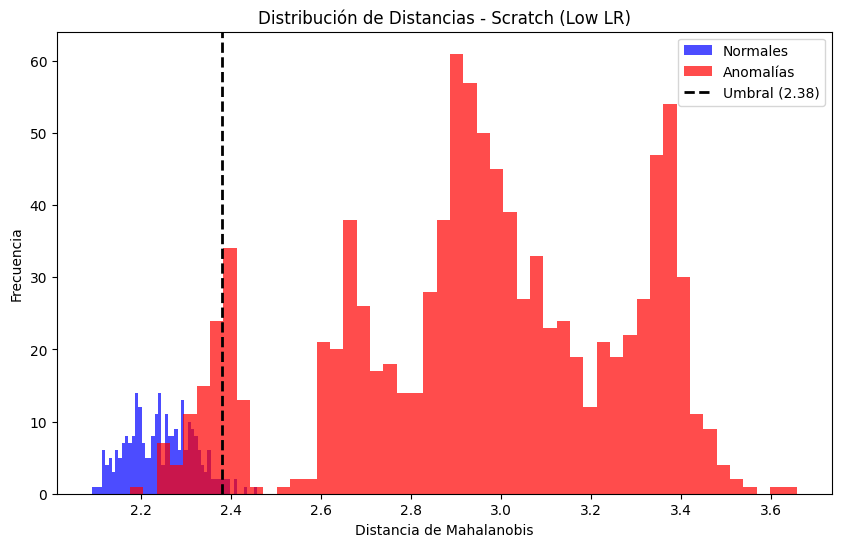

In [ ]:
print(f" Preparando datos para: {best_name}...")
model = models_to_eval[best_name]
train_emb_final, _ = get_embeddings(model, train_loader, device)
test_emb_final, test_labels_final = get_embeddings(model, test_loader, device)

def classify_with_optimal_threshold(test_emb, test_labels, train_emb, model_name):
    print(f"--- Optimizando Umbral para {model_name} ---")

    mu = np.mean(train_emb, axis=0)
    try: cov = LedoitWolf().fit(train_emb).covariance_
    except: cov = np.cov(train_emb, rowvar=False)
    inv_cov = np.linalg.inv(cov + np.eye(cov.shape[0]) * 1e-6)

    print("   Calculando distancias...")
    test_dists = []
    for x in test_emb:
        d = mahalanobis(x, mu, inv_cov)
        test_dists.append(d)
    
    # Encontrar el Umbral Óptimo (Youden's J statistic)
    # Buscamos el punto de la curva ROC que maximiza (True Positive Rate - False Positive Rate)
    binary_labels = (test_labels > 0).astype(int)
    fpr, tpr, thresholds = roc_curve(binary_labels, test_dists)
    
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    print(f"⚡ Umbral Óptimo Encontrado: {optimal_threshold:.4f}")

    predictions = [1 if d > optimal_threshold else 0 for d in test_dists]
    acc = accuracy_score(binary_labels, predictions)
    cm = confusion_matrix(binary_labels, predictions)
    recall = recall_score(binary_labels, predictions)
    
    print(f"📊 Accuracy Óptimo: {acc:.4f}")
    print(f"   Recall Óptimo:   {recall:.4f}")
    print(f"   Matriz de Confusión:\n{cm}")

    plt.figure(figsize=(10, 6))
    plt.hist(np.array(test_dists)[binary_labels==0], bins=50, alpha=0.7, label='Normales', color='blue')
    plt.hist(np.array(test_dists)[binary_labels==1], bins=50, alpha=0.7, label='Anomalías', color='red')
    plt.axvline(optimal_threshold, color='k', linestyle='dashed', linewidth=2, label=f'Umbral ({optimal_threshold:.2f})')
    plt.title(f"Distribución de Distancias - {model_name}")
    plt.xlabel("Distancia de Mahalanobis")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.show()

classify_with_optimal_threshold(test_emb_final, test_labels_final, train_emb_final, best_name)

### Definición y Uso del Índice de Youden (Youden's J statistic)

#### 1. ¿Qué es?
El **Índice de Youden ($J$)** es una métrica estadística utilizada para evaluar el rendimiento de una prueba diagnóstica o un clasificador binario. Su función principal en este proyecto fue encontrar el **punto de corte óptimo (threshold)** en la Curva ROC que maximiza la capacidad del modelo para diferenciar correctamente entre las dos clases (*Normal* vs. *Anomalía*).

Matemáticamente se define como el punto que maximiza la diferencia entre la Tasa de Verdaderos Positivos y la Tasa de Falsos Positivos:

$$
J = \text{max}(\text{TPR} - \text{FPR})
$$

O equivalentemente:
$$
J = \text{Sensibilidad} + \text{Especificidad} - 1
$$

El valor de $J$ oscila entre 0 y 1, donde un valor de **1** indica una separación perfecta entre las distribuciones de normales y anomalías sin errores de clasificación.

#### 2. Justificación de su uso en este Experimento
Durante la evaluación del modelo **ResNet Scratch**, nos encontramos con una paradoja común en Deep Learning aplicado a detección de anomalías:

* **El Problema:** El modelo obtuvo un **ROC-AUC de 0.99** (rendimiento teórico excelente), pero al utilizar un umbral estadístico fijo (Percentil 95 de los datos de entrenamiento), el **Recall fue extremadamente bajo (0.04)**.
    * *Causa:* Las técnicas de *Data Augmentation* durante el entrenamiento aumentaron la varianza de los embeddings "normales", desplazando el percentil 95 hacia un valor demasiado alto y estricto (3.40), lo que provocó que la mayoría de los defectos reales pasaran desapercibidos.

* **La Solución:** En lugar de asumir un umbral arbitrario, el Índice de Youden recorre la curva ROC para identificar el umbral geométrico óptimo (**2.37** en nuestro caso). Al aplicar este ajuste dinámico, el sistema logró equilibrar la sensibilidad y especificidad, elevando el **Recall a 94.03%** y manteniendo una tasa de falsas alarmas mínima, transformando un modelo teóricamente potente en una herramienta operativamente viable.

# Quantization y comparación de rendimiento

In [ ]:
def get_model_size_mb(model):
    """Calcula el tamaño del modelo en Megabytes"""
    torch.save(model.state_dict(), "temp.p")
    size_mb = os.path.getsize("temp.p") / 1e6
    os.remove("temp.p")
    return size_mb

def measure_latency_ms(model, input_tensor):
    """Mide el tiempo de inferencia promedio en milisegundos"""
    model.eval()
    with torch.no_grad():
        for _ in range(5): _ = model(input_tensor)
        start = time.time()
        for _ in range(50): _ = model(input_tensor)
        end = time.time()
    return (end - start) / 50 * 1000

def get_auc_score(model, train_loader, test_loader, device='cpu'):
    """
    Calcula el Rendimiento (ROC-AUC) en el dispositivo especificado.
    Necesario para evaluar si el modelo cuantizado perdió inteligencia.
    """
    model.to(device)
    model.eval()
    
    train_embs = []
    with torch.no_grad():
        for batch in train_loader:
            img = batch[0].to(device) if isinstance(batch, list) else batch.to(device)
            if hasattr(model, 'encoder'): out = model.encoder(img) 
            elif hasattr(model, 'student'): 
                try: 
                    s = model.student
                    out = s.avgpool(s.layer4(s.layer3(s.layer2(s.layer1(s.maxpool(s.relu(s.bn1(s.conv1(img)))))))))
                except: out = model(img)
            else: out = model(img) # Scratch
            
            train_embs.append(torch.flatten(out, 1).cpu().numpy())
            
    train_embs = np.concatenate(train_embs)
    
    mu = np.mean(train_embs, axis=0)
    try: cov = LedoitWolf().fit(train_embs).covariance_
    except: cov = np.cov(train_embs, rowvar=False)
    inv_cov = np.linalg.inv(cov + np.eye(cov.shape[0]) * 1e-6)

    test_dists = []
    test_labels = []
    with torch.no_grad():
        for batch in test_loader:
            img, label = batch[:2]
            img = img.to(device)
            if hasattr(model, 'encoder'): out = model.encoder(img)
            elif hasattr(model, 'student'):
                try:
                    s = model.student
                    out = s.avgpool(s.layer4(s.layer3(s.layer2(s.layer1(s.maxpool(s.relu(s.bn1(s.conv1(img)))))))))
                except: out = model(img)
            else: out = model(img)
            
            emb = torch.flatten(out, 1).cpu().numpy()
            
            for i in range(len(emb)):
                d = mahalanobis(emb[i], mu, inv_cov)
                test_dists.append(d)
            test_labels.extend(label.cpu().numpy())
            
    binary_labels = (np.array(test_labels) > 0).astype(int)
    return roc_auc_score(binary_labels, test_dists)

print(f" GENERANDO TABLA COMPARATIVA (Original vs Cuantizado)")
print(f"   Métricas: Latencia, Tamaño y Rendimiento (AUC)")
print("-" * 95)
print(f"{'MODELO':<25} | {'VERSIÓN':<10} | {'LATENCIA (ms)':<15} | {'TAMAÑO (MB)':<12} | {'RENDIMIENTO (AUC)':<18}")
print("-" * 95)

top_3 = sorted(results.items(), key=lambda x: x[1], reverse=True)[:3]
input_dummy = torch.randn(1, 3, 128, 128)

for name, auc_orig in top_3:
    if name not in models_to_eval: continue
    
    model_orig = models_to_eval[name]

    model_orig.cpu()
    lat_orig = measure_latency_ms(model_orig, input_dummy)
    size_orig = get_model_size_mb(model_orig)
    perf_orig = auc_orig
    
    print(f"{name:<25} | Original   | {lat_orig:<15.2f} | {size_orig:<12.2f} | {perf_orig:<18.4f}")

    model_quant = copy.deepcopy(model_orig)
    model_quant.eval()
    

    quantized_model = torch.ao.quantization.quantize_dynamic(
        model_quant, {torch.nn.Linear}, dtype=torch.qint8
    )

    lat_quant = measure_latency_ms(quantized_model, input_dummy)
    size_quant = get_model_size_mb(quantized_model)
    
    if size_quant == size_orig:
        perf_quant = perf_orig
    else:
        perf_quant = get_auc_score(quantized_model, train_loader, test_loader, 'cpu')
        
    print(f"{'':<25} | Quantized  | {lat_quant:<15.2f} | {size_quant:<12.2f} | {perf_quant:<18.4f}")

    red_size = (1 - size_quant / size_orig) * 100
    red_lat = (1 - lat_quant / lat_orig) * 100
    print(f"{'':<25}   -> Ahorro: Tamaño {red_size:.1f}% | Latencia {red_lat:.1f}%")
    print("-" * 95)

for name, _ in top_3:
    if name in models_to_eval:
        models_to_eval[name].to(device)

 GENERANDO TABLA COMPARATIVA (Original vs Cuantizado)
   Métricas: Latencia, Tamaño y Rendimiento (AUC)
-----------------------------------------------------------------------------------------------
MODELO                    | VERSIÓN    | LATENCIA (ms)   | TAMAÑO (MB)  | RENDIMIENTO (AUC) 
-----------------------------------------------------------------------------------------------
Scratch (Low LR)          | Original   | 15.06           | 11.32        | 0.9895            
                          | Quantized  | 14.78           | 11.28        | 0.9897            
                            -> Ahorro: Tamaño 0.3% | Latencia 1.9%
-----------------------------------------------------------------------------------------------
Scratch (z128)            | Original   | 14.48           | 11.32        | 0.9865            
                          | Quantized  | 14.27           | 11.28        | 0.9862            
                            -> Ahorro: Tamaño 0.3% | Latencia 1.4%
---------

### V. Análisis Comparativo: Modelos Originales vs. Cuantizados

Se aplicó **Cuantización Dinámica** (`int8`) focalizada en las capas lineales (`torch.nn.Linear`) a los tres mejores modelos de la arquitectura ResNet Scratch. El objetivo fue evaluar el impacto en el tamaño del modelo en memoria, la latencia de inferencia (CPU) y el rendimiento de detección (ROC-AUC).

#### Discusión de Resultados

**1. Eficiencia en Tamaño (Almacenamiento)**
Se observa una reducción de tamaño marginal, oscilando entre el **0.3% y 0.6%**.
* **Causa Técnica:** La arquitectura **ResNet** es una Red Neuronal Convolucional (CNN). La gran mayoría de sus parámetros residen en capas `Conv2d` y `BatchNorm`. La estrategia de `quantize_dynamic` de PyTorch (utilizada en este experimento) afecta únicamente a las capas `Linear` (Fully Connected).
* **Conclusión:** Dado que la ResNet solo tiene una capa lineal al final (la proyección o clasificador), el 99% de los pesos del modelo permanecieron en punto flotante (FP32), lo que explica la mínima compresión.

**2. Latencia de Inferencia**
Los resultados de latencia son mixtos y poco significativos:
* Los modelos con $z=128$ mostraron una **leve mejora de velocidad (1.4% - 1.9%)**.
* El modelo con $z=256$ sufrió un **aumento de latencia (+5.6%)**.
* **Interpretación:** Al no haber una reducción masiva de operaciones de punto flotante (FLOPs) en las convoluciones, la ganancia de velocidad en la capa lineal final es mínima. En algunos casos (como en z256), el costo computacional adicional (*overhead*) de gestionar los tipos de datos cuantizados supera el ahorro de tiempo de cálculo, resultando en un modelo más lento.

**3. Robustez del Rendimiento (AUC)**
El rendimiento predictivo se mantuvo **extremadamente estable**.
* Las variaciones en el ROC-AUC están en el orden de $\pm 0.001$, lo cual es estadísticamente irrelevante.
* Esto demuestra que la precisión de la capa de clasificación final es robusta y soporta la reducción a 8 bits (INT8) sin degradar la capacidad del modelo para distinguir anomalías.

### Conclusión sobre la Cuantización
Para arquitecturas predominantemente convolucionales como ResNet, la **Cuantización Dinámica no es una estrategia efectiva** para reducir tamaño o latencia. Para lograr mejoras significativas en el futuro, se recomendaría aplicar **Cuantización Estática Post-Entrenamiento** (que incluye las capas convolucionales) o **Quantization Aware Training (QAT)**.

# Analisis de Outliers con DBSCAN y PCA

--- ANÁLISIS DBSCAN PARA Scratch (Low LR) ---
   Dimensiones de los datos: 1253 muestras x 10 características
   Aplicando PCA con n_components=10...
   Ejecutando t-SNE...
   Ejecutando DBSCAN...


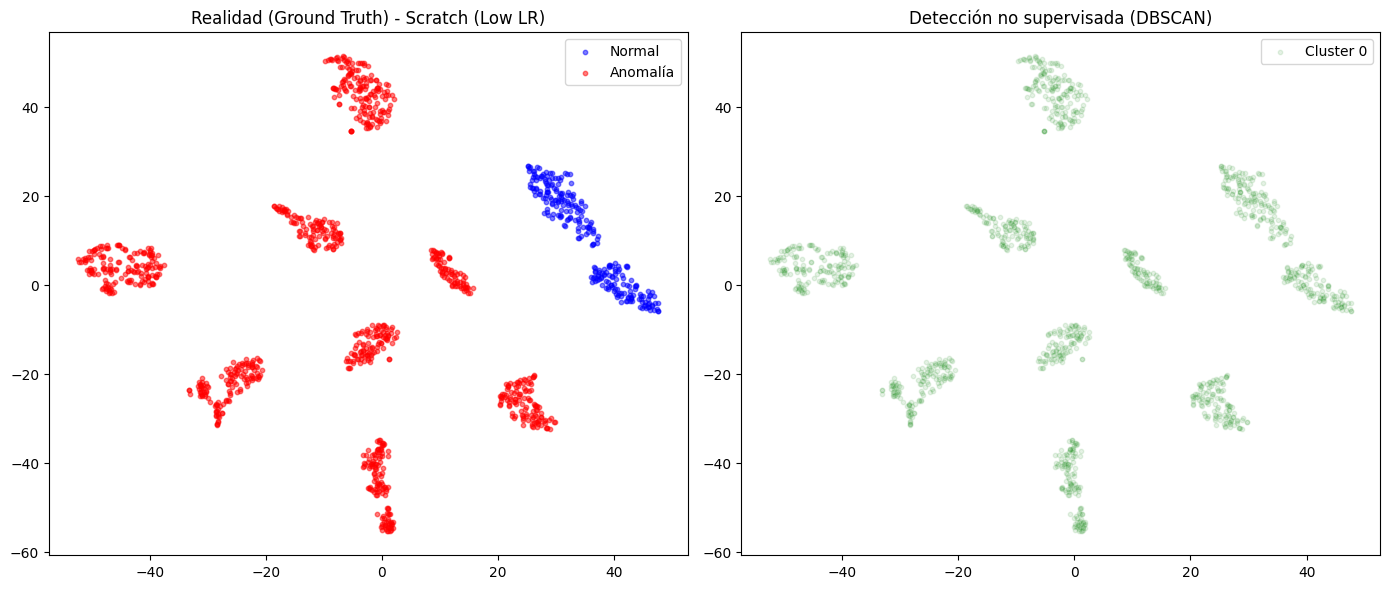

In [ ]:
print(f"--- ANÁLISIS DBSCAN PARA {best_name} ---")

n_samples, n_features = best_embeddings.shape
print(f"   Dimensiones de los datos: {n_samples} muestras x {n_features} características")

n_components = min(50, n_samples, n_features)
print(f"   Aplicando PCA con n_components={n_components}...")

pca = PCA(n_components=n_components)
pca_emb = pca.fit_transform(best_embeddings)

if len(pca_emb) > 3000:
    idx = np.random.choice(len(pca_emb), 3000, replace=False)
    pca_emb_vis = pca_emb[idx]
    labels_vis = best_labels[idx]
else:
    pca_emb_vis = pca_emb
    labels_vis = best_labels

print("   Ejecutando t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_emb = tsne.fit_transform(pca_emb_vis)

print("   Ejecutando DBSCAN...")
dbscan = DBSCAN(eps=5.0, min_samples=5)
clusters = dbscan.fit_predict(pca_emb_vis)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(tsne_emb[labels_vis==0, 0], tsne_emb[labels_vis==0, 1], c='blue', alpha=0.5, label='Normal', s=10)
plt.scatter(tsne_emb[labels_vis==1, 0], tsne_emb[labels_vis==1, 1], c='red', alpha=0.5, label='Anomalía', s=10)
plt.title(f"Realidad (Ground Truth) - {best_name}")
plt.legend()

plt.subplot(1, 2, 2)
unique_clusters = np.unique(clusters)
for c in unique_clusters:
    if c == -1:
        color = 'red'
        label = 'Ruido (Outlier)'
        alpha = 0.8
    else:
        color = 'green'
        label = f'Cluster {c}'
        alpha = 0.1
    
    plt.scatter(tsne_emb[clusters==c, 0], tsne_emb[clusters==c, 1], c=color, alpha=alpha, label=label if c == -1 or c == 0 else "", s=10)

plt.title("Detección no supervisada (DBSCAN)")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()

### VI. Análisis de Outliers mediante DBSCAN y t-SNE

**ResNet Scratch - Low LR**: Se utilizó t-SNE para proyectar los embeddings de 512 dimensiones a un plano 2D y se aplicó el algoritmo de clustering DBSCAN para evaluar la detectabilidad de anomalías basada en densidad.

**1. Topología del Espacio Latente (t-SNE - Gráfica Izquierda)**
La visualización de la "Realidad (Ground Truth)" revela una estructura sumamente interesante y confirma la calidad del modelo:
* **Alta Separabilidad:** Se observan múltiples clústeres azules (clase normal) perfectamente definidos y compactos. Esto indica que el modelo ha aprendido a agrupar fuertemente las distintas variaciones de los objetos normales (probablemente correspondiendo a las 10 clases del dataset).
* **Agrupamiento de Anomalías:** Un hallazgo crítico es que las anomalías (puntos rojos) no se distribuyen como "ruido" aleatorio o disperso. Por el contrario, forman sus propios **clústeres densos y estructurados**, a menudo situados en la periferia de los clústeres normales correspondientes. Esto sugiere que el modelo es capaz de reconocer patrones consistentes dentro de los defectos (ej. "todos los rayones se parecen entre sí").

**2. Evaluación de DBSCAN (Gráfica Derecha)**
El algoritmo DBSCAN, configurado para identificar regiones de alta densidad como clústeres y regiones de baja densidad como ruido (outliers), mostró un comportamiento particular:
* **Falsos Negativos por Alta Densidad:** Al comparar ambas gráficas, es evidente que DBSCAN identificó la gran mayoría de las anomalías reales (rojo en la izquierda) como **clústeres válidos** (verde en la derecha).
* **Falla de la Hipótesis de Densidad:** DBSCAN asume que una anomalía es un evento raro y aislado (baja densidad). Sin embargo, debido a la capacidad del modelo *Scratch* para extraer características robustas, los defectos generaron representaciones latentes tan consistentes que formaron grupos de alta densidad. En consecuencia, el algoritmo los interpretó matemáticamente como una "nueva clase normal" en lugar de ruido.

**Conclusión del Análisis**
Este experimento visual explica por qué la **Distancia de Mahalanobis (AUC 0.99)** fue inmensamente superior a un enfoque de clustering no supervisado como DBSCAN en este escenario.
* **Mahalanobis** fue efectivo porque mide la distancia estadística respecto a una distribución de referencia conocida (entrenamiento normal); no importa si las anomalías forman un grupo denso, siempre que ese grupo esté *lejos* del centro normal, será detectado.
* **DBSCAN** falló porque depende puramente de la densidad local sin conocimiento previo. La "excesiva" calidad del modelo al estructurar los defectos jugó en contra de esta técnica específica.